# Limpieza de Datos a un nuevo Excel

Como paso posterior a la recopilación de variables en un libro excel (cada variable se ubica en una hoja distinta), tenemos que realizar la limpieza de estas variables.
Para ello crearemos otro libro excel con fechas trimestrales desde el 2003 al 2024, asociando a cada trimestre el valor de cada variable.

# 0. Librerías, Dataset y configuraciones iniciales

In [1]:
import pandas as pd
import numpy as np
import locale

archivo = "Recoleccion_variables.xlsx"

# Dataframe con las variables limpias y ordenadas trimestralmente
df_clean = pd.DataFrame()

# Asignamos estas dos constantes para establecer los límites que vamos a poner para las fechas
__FECHA_INICIO = pd.to_datetime('2003-01-01')
__FECHA_FIN = pd.to_datetime('2023-12-31')

In [2]:
def analizar_nan(df):
    """
    Analiza valores NaN por columna con estadísticas detalladas - función generica
    """
    total_filas = len(df)
    nan_counts = df.isnull().sum()
    nan_percentages = (nan_counts / total_filas * 100).round(2)
    
    # Crear DataFrame resumen
    resumen = pd.DataFrame({
        'Columna': nan_counts.index,
        'NaN_Count': nan_counts.values,
        'NaN_Percentage': nan_percentages.values,
        'Datos_Válidos': total_filas - nan_counts.values,
        'Total_Filas': total_filas
    })
    
    # Ordenar por mayor cantidad de NaN
    resumen = resumen.sort_values('NaN_Count', ascending=False)
    
    return resumen

# 1. Numero de hipotecas

In [3]:
df_1 = pd.read_excel(archivo, sheet_name="NumeroHipotecas_mes")
df_1.head()

,Variable1,Valor1,Variable2,Valor2,Variable3,Valor3,Variable4,Valor4,PERIODO,VALOR
0,Naturaleza de la finca,Viviendas,Concepto financiero,Número de hipotecas,Total Nacional,Total Nacional,Cambios de conceptos,Base nueva. Mensual,2025M02,39.084
1,Naturaleza de la finca,Viviendas,Concepto financiero,Número de hipotecas,Total Nacional,Total Nacional,Cambios de conceptos,Base nueva. Mensual,2025M01,38.058
2,Naturaleza de la finca,Viviendas,Concepto financiero,Número de hipotecas,Total Nacional,Total Nacional,Cambios de conceptos,Base nueva. Mensual,2024M12,32.249
3,Naturaleza de la finca,Viviendas,Concepto financiero,Número de hipotecas,Total Nacional,Total Nacional,Cambios de conceptos,Base nueva. Mensual,2024M11,38.497
4,Naturaleza de la finca,Viviendas,Concepto financiero,Número de hipotecas,Total Nacional,Total Nacional,Cambios de conceptos,Base nueva. Mensual,2024M10,51.535


In [4]:
# Eliminar las primeras filas con metadatos que no nos interesan
df_1.drop(df_1.columns[[0,1,2,3,4,5,6,7]],axis=1,inplace=True)

#Renombramos las dos columnas
df_1 = df_1.rename(columns={"PERIODO": "Fecha", "VALOR": "Numero Hipotecas"})
# Comprobar el tipo de dato de la columna valor
print("El formato de la columna número de hipotecas es: ",df_1["Numero Hipotecas"].dtype)

df_1.head()

El formato de la columna número de hipotecas es:  float64


,Fecha,Numero Hipotecas
0,2025M02,39.084
1,2025M01,38.058
2,2024M12,32.249
3,2024M11,38.497
4,2024M10,51.535


## Ajuste de la columna de Fecha

In [5]:
# Asegurarse de que la columna Fechas es string y eliminar espacios sobrantes
df_1["Fecha"] = df_1["Fecha"].astype(str).str.strip()

# Extrae año y mes
df_1["Año"] = df_1["Fecha"].str[:4].astype(int)
df_1["Mes"] = df_1["Fecha"].str[-2:].astype(int)

# Crea una columna de tipo datetime (día 1 de cada mes)
df_1["Fecha"] = pd.to_datetime(dict(year=df_1["Año"], month=df_1["Mes"], day=1))

# Eliminar columnas temporales
df_1 = df_1.drop(columns=["Año", "Mes"])

df_1.head()

,Fecha,Numero Hipotecas
0,2025-02-01,39.084
1,2025-01-01,38.058
2,2024-12-01,32.249
3,2024-11-01,38.497
4,2024-10-01,51.535


## Ajuste de la columna de Numero Hipotecas

Esto lo realizamos por que nos hemos dado cuenta que en Python detecta el punto como separador de miles pero después al pasarlo al excel, según como esté configurado, puede pasarlo como decimales, lo que daría errores. De esta manera nos quitamos esos problemas

In [6]:
df_1["Numero Hipotecas"] = (df_1["Numero Hipotecas"] * 1000).round().astype(int)
df_1.head()

,Fecha,Numero Hipotecas
0,2025-02-01,39084
1,2025-01-01,38058
2,2024-12-01,32249
3,2024-11-01,38497
4,2024-10-01,51535


## Pasar a Trimestral y añadir al dataframe final

In [7]:
# Ordenamos las fechas
df_1 = df_1.sort_values("Fecha")

# Pasamos a trimestral, en este caso sumando los valores de cada mes
df_1 = df_1.resample("QE", on="Fecha").sum().reset_index()
# Guardamos el DataFrame limpio en el diccionario
df_clean = df_1

df_clean.head()

,Fecha,Numero Hipotecas
0,2003-03-31,263600
1,2003-06-30,247071
2,2003-09-30,236977
3,2003-12-31,241791
4,2004-03-31,283170


## Establecer los límites superiores e inferiores del DF

In [8]:
df_clean = df_clean[(df_clean['Fecha'] >= __FECHA_INICIO) & (df_clean['Fecha'] <= __FECHA_FIN)]

print(df_clean.head())
print(len(df_clean))

       Fecha  Numero Hipotecas
0 2003-03-31            263600
1 2003-06-30            247071
2 2003-09-30            236977
3 2003-12-31            241791
4 2004-03-31            283170
84


# 2. Importe Total Hipotecas

In [9]:
df_2 = pd.read_excel(archivo, sheet_name="importeHipotecas_mes")
df_2.head()

,Total Nacional,Unnamed: 1
0,2025M02,6.136.900
1,2025M01,5.793.680
2,2024M12,4.913.994
3,2024M11,5.897.343
4,2024M10,7.758.879


In [10]:
#Renombramos las columnas
df_2 = df_2.rename(columns={"Total Nacional": "Fecha", "Unnamed: 1": "Importe Hipotecas"})
# Comprobar el tipo de dato de la columna Importe Hipotecas
print("El formato de la columna Importe Hipotecas es: ",df_2["Importe Hipotecas"].dtype)

df_2.head()

El formato de la columna Importe Hipotecas es:  object


,Fecha,Importe Hipotecas
0,2025M02,6.136.900
1,2025M01,5.793.680
2,2024M12,4.913.994
3,2024M11,5.897.343
4,2024M10,7.758.879


## Ajuste de la columa de Importe Hipotecas

In [11]:
# Pasar la columna Importe Hipotecas de object a float
# Viene dato de la forma 6.000.000 y está en miles de euros
df_2["Importe Hipotecas"] = df_2["Importe Hipotecas"].str.replace(".", "", regex=False).astype(float) * 1000

## Ajuste de la columna de Fecha

In [12]:
# Asegurarse de que las columnas son strings y eliminar espacios sobrantes
df_2["Fecha"] = df_2["Fecha"].astype(str).str.strip()
# Extrae año y mes
df_2["Año"] = df_2["Fecha"].str[:4].astype(int)
df_2["Mes"] = df_2["Fecha"].str[-2:].astype(int)

# Crea una columna de tipo datetime (día 1 de cada mes)
df_2["Fecha"] = pd.to_datetime(dict(year=df_2["Año"], month=df_2["Mes"], day=1))

# Eliminar columnas temporales
df_2 = df_2.drop(columns=["Año", "Mes"])

df_2.head()

,Fecha,Importe Hipotecas
0,2025-02-01,6.136900e+09
1,2025-01-01,5.793680e+09
2,2024-12-01,4.913994e+09
3,2024-11-01,5.897343e+09
4,2024-10-01,7.758879e+09


## Pasar a Trimestral y ajustar límites

In [13]:
# Ordenar por fecha
df_2 = df_2.sort_values("Fecha")

# Pasar a trimestral (suma en este caso)
df_2 = df_2.resample("QE", on="Fecha").sum().reset_index()

df_2 = df_2[(df_2['Fecha'] >= __FECHA_INICIO) & (df_2['Fecha'] <= __FECHA_FIN)]


## Añadir al dataframe final

In [14]:
df_clean = df_clean.merge(df_2, on="Fecha", how="outer")

df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas
0,2003-03-31,263600,2.417559e+10
1,2003-06-30,247071,2.340044e+10
2,2003-09-30,236977,2.397833e+10
3,2003-12-31,241791,2.462120e+10
4,2004-03-31,283170,3.002192e+10


# 3. Valor Medio / Mes

In [15]:
# En este caso, vamos a calcular esta variable como Importe Total Hipotecas / Número de hipotecas
# Unimos los dos DataFrames por la columna 'Fecha'
df_3 = pd.merge(df_1, df_2, on="Fecha", how="inner")
# Creamos la nueva columna calculada
df_3["valor_medio_hipotecas"] = (df_3["Importe Hipotecas"] / df_3["Numero Hipotecas"]).round(2)
df_3 = df_3.drop(columns=["Importe Hipotecas", "Numero Hipotecas"])
df_3.head(10)

,Fecha,valor_medio_hipotecas
0,2003-03-31,91713.17
1,2003-06-30,94711.40
2,2003-09-30,101184.20
3,2003-12-31,101828.44
4,2004-03-31,106020.83
5,2004-06-30,107479.23
6,2004-09-30,114014.39
7,2004-12-31,113890.31
8,2005-03-31,119738.46
9,2005-06-30,121246.85


## Añadir al dataframe final

In [16]:
df_clean = df_clean.merge(df_3, on="Fecha", how="outer")

df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas
0,2003-03-31,263600,2.417559e+10,91713.17
1,2003-06-30,247071,2.340044e+10,94711.40
2,2003-09-30,236977,2.397833e+10,101184.20
3,2003-12-31,241791,2.462120e+10,101828.44
4,2004-03-31,283170,3.002192e+10,106020.83


# 4. Tipo interés Medio / Mes

In [17]:
df_4 = pd.read_excel(archivo, sheet_name="tipoInteresMedio_mes")
df_4.head()

,Variable1,Valor1,Variable2,Valor2,Variable3,Valor3,Variable4,Valor4,Variable5,Valor5,PERIODO,VALOR
0,Naturaleza de la finca,Viviendas,Concepto financiero,Tipo de interés medio,Total Nacional,Total Nacional,Cambios de conceptos,Base nueva. Mensual,Tipo de interés,Total,2025M02,"2,96"
1,Naturaleza de la finca,Viviendas,Concepto financiero,Tipo de interés medio,Total Nacional,Total Nacional,Cambios de conceptos,Base nueva. Mensual,Tipo de interés,Total,2025M01,"3,08"
2,Naturaleza de la finca,Viviendas,Concepto financiero,Tipo de interés medio,Total Nacional,Total Nacional,Cambios de conceptos,Base nueva. Mensual,Tipo de interés,Total,2024M12,"3,25"
3,Naturaleza de la finca,Viviendas,Concepto financiero,Tipo de interés medio,Total Nacional,Total Nacional,Cambios de conceptos,Base nueva. Mensual,Tipo de interés,Total,2024M11,"3,28"
4,Naturaleza de la finca,Viviendas,Concepto financiero,Tipo de interés medio,Total Nacional,Total Nacional,Cambios de conceptos,Base nueva. Mensual,Tipo de interés,Total,2024M10,"3,12"


In [18]:
# Eliminar las primeras filas con metadatos que no nos interesan
df_4.drop(df_4.columns[[0,1,2,3,4,5,6,7,8,9]],axis=1,inplace=True)

#Renombramos las columnas
df_4 = df_4.rename(columns={"PERIODO": "Fecha", "VALOR": "Tipo interes Medio"})
# Comprobar el tipo de dato de la columna Tipo interes Medio
print("El formato de la columna Tipo interes Medio es: ",df_4["Tipo interes Medio"].dtype) 

df_4.head()

El formato de la columna Tipo interes Medio es:  object


,Fecha,Tipo interes Medio
0,2025M02,"2,96"
1,2025M01,"3,08"
2,2024M12,"3,25"
3,2024M11,"3,28"
4,2024M10,"3,12"


## Ajuste de la columna Tipo interes Medio

In [19]:
# La columna Tipo interes Medio es de tipo object, del estilo "2,96"
# Pasar la columna Tipo interes Medio de object a float
df_4["Tipo interes Medio"] = (
    df_4["Tipo interes Medio"]
    .astype(str)                        # Asegura que todo es string
    .str.strip()                        # Elimina espacios al inicio/final
    .str.replace("\u202f", "", regex=True)  # Elimina espacios finos (INE los usa a veces)
    .str.replace(",", ".", regex=False)     # Reemplaza coma por punto
)

# Ahora convertir a float
df_4["Tipo interes Medio"] = pd.to_numeric(df_4["Tipo interes Medio"], errors="coerce")
df_4.head()

,Fecha,Tipo interes Medio
0,2025M02,2.96
1,2025M01,3.08
2,2024M12,3.25
3,2024M11,3.28
4,2024M10,3.12


## Ajuste de la columna Fecha

In [20]:
# Asegurarse de que la columna Fechas es string y eliminar espacios sobrantes
df_4["Fecha"] = df_4["Fecha"].astype(str).str.strip()

# Extrae año y mes
df_4["Año"] = df_4["Fecha"].str[:4].astype(int)
df_4["Mes"] = df_4["Fecha"].str[-2:].astype(int)

# Crea una columna de tipo datetime (día 1 de cada mes)
df_4["Fecha"] = pd.to_datetime(dict(year=df_4["Año"], month=df_4["Mes"], day=1))

# Eliminar columnas temporales
df_4 = df_4.drop(columns=["Año", "Mes"])

df_4.head()

,Fecha,Tipo interes Medio
0,2025-02-01,2.96
1,2025-01-01,3.08
2,2024-12-01,3.25
3,2024-11-01,3.28
4,2024-10-01,3.12


## Pasar a Trimestral y ajustar límites

In [21]:
# Ordenar por fecha
df_4 = df_4.sort_values("Fecha")

# Pasar a trimestral (media en este caso)
df_4 = df_4.resample("QE", on="Fecha").mean().reset_index() 

df_4 = df_4[(df_4['Fecha'] >= __FECHA_INICIO) & (df_4['Fecha'] <= __FECHA_FIN)]

## Añadir al dataframe final

In [22]:
df_clean = df_clean.merge(df_4, on="Fecha", how="outer")

df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000


# 5. Tasa de paro

In [23]:
df_5 = pd.read_excel(archivo, sheet_name="TasaParo_trim")
df_5.head(5)

,Comunidades y Ciudades Autónomas,Sexo,Edad,Periodo,Total
0,Total Nacional,Ambos sexos,Total,2025T1,"11,36"
1,Total Nacional,Ambos sexos,Total,2024T4,"10,61"
2,Total Nacional,Ambos sexos,Total,2024T3,"11,21"
3,Total Nacional,Ambos sexos,Total,2024T2,"11,27"
4,Total Nacional,Ambos sexos,Total,2024T1,"12,29"


In [24]:
# Eliminar las primeras filas con metadatos que no nos interesan
df_5.drop(df_5.columns[[0,1,2]],axis=1,inplace=True)

#Renombramos las columnas
df_5 = df_5.rename(columns={"Periodo": "Fecha", "Total": "Tasa Paro (%)"})

df_5.head(5)



,Fecha,Tasa Paro (%)
0,2025T1,"11,36"
1,2024T4,"10,61"
2,2024T3,"11,21"
3,2024T2,"11,27"
4,2024T1,"12,29"


In [25]:
print(df_5.dtypes)

Fecha            object
Tasa Paro (%)    object
dtype: object


In [26]:
df_5["Tasa Paro (%)"] = (
    df_5["Tasa Paro (%)"]
    .astype(str)                        # Asegura que todo es string
    .str.strip()                        # Elimina espacios al inicio/final
    .str.replace("\u202f", "", regex=True)  # Elimina espacios finos (INE los usa a veces)
    .str.replace(",", ".", regex=False)     # Reemplaza coma por punto
)

# Ahora convertir a float
df_5["Tasa Paro (%)"] = pd.to_numeric(df_5["Tasa Paro (%)"], errors="coerce")

print(df_5.dtypes)
print(df_5.head())

Fecha             object
Tasa Paro (%)    float64
dtype: object
    Fecha  Tasa Paro (%)
0  2025T1          11.36
1  2024T4          10.61
2  2024T3          11.21
3  2024T2          11.27
4  2024T1          12.29


In [27]:
df_5["Fecha"] = df_5["Fecha"].astype(str).str.strip()

df_5["Año"] = df_5["Fecha"].str[:4].astype(int)
df_5["Trimestre"] = df_5["Fecha"].str[-1:].astype(int)

df_5["Mes"] = df_5["Trimestre"].map({1: 3, 2: 6, 3: 9, 4: 12})

df_5["Fecha"] = pd.to_datetime(dict(year=df_5["Año"], month=df_5["Mes"], day=1))
df_5["Fecha"] = df_5["Fecha"] + pd.offsets.QuarterEnd(0)

df_5 = df_5.drop(columns=["Año", "Trimestre", "Mes"])

df_5.head()

,Fecha,Tasa Paro (%)
0,2025-03-31,11.36
1,2024-12-31,10.61
2,2024-09-30,11.21
3,2024-06-30,11.27
4,2024-03-31,12.29


In [28]:
df_5 = df_5[(df_5['Fecha'] >= __FECHA_INICIO) & (df_5['Fecha'] <= __FECHA_FIN)]

print(df_5.head())
print(len(df_5))

       Fecha  Tasa Paro (%)
5 2023-12-31          11.80
6 2023-09-30          11.89
7 2023-06-30          11.67
8 2023-03-31          13.38
9 2022-12-31          12.99
84


In [29]:
df_clean = df_clean.merge(df_5, on="Fecha", how="outer")

df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%)
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50


# 6. Tipo Contrato 

Este conjunto de datos divide la cantidad de contratos de dos tipos, de tipo temporal o de tipo fijo, vamos a crear dos columnas a partir de la información de este conjunto de datos, para finalmente quedarnos por un lado con la cantidad de contratos temporales y la cantidad de contratos indefinidos.

In [30]:
df_6 = pd.read_excel(archivo, sheet_name="TipoContrato_trim")

df_6.drop(df_6.columns[[0,1,2]],axis=1,inplace=True)

print(df_6.head(5))


  Tipo de contrato o relación laboral Periodo      Total
0       De duración indefinida: Total  2025T1  15.702,70
1       De duración indefinida: Total  2024T4  15.712,50
2       De duración indefinida: Total  2024T3  15.601,50
3       De duración indefinida: Total  2024T2  15.498,80
4       De duración indefinida: Total  2024T1  15.226,80


## Mapeo de los resultados para que sean dos columnas calculadas

In [31]:
#print(f"Valores únicos: {list(df_6["Tipo de contrato o relación laboral"].unique())}")

In [32]:
df_6_contratos = pd.DataFrame()
df_6_contratos["Periodo"] = df_6["Periodo"].unique()
df_6_contratos = df_6_contratos.sort_values("Periodo").reset_index(drop=True)

# Asignar los valores de cada tipo de contrato
df_6_contratos["Contratos indefinidos"] = df_6_contratos["Periodo"].map(
    df_6[df_6["Tipo de contrato o relación laboral"].str.contains("indefinida", case=False)]\
        .set_index("Periodo")["Total"]
)
df_6_contratos["Contratos temporales"] = df_6_contratos["Periodo"].map(
    df_6[df_6["Tipo de contrato o relación laboral"].str.contains("Temporal", case=False)]\
        .set_index("Periodo")["Total"]
)

print(df_6_contratos.head())
print(len(df_6_contratos))

  Periodo Contratos indefinidos Contratos temporales
0  2002T1              9.039,20             4.264,30
1  2002T2              9.209,30             4.375,70
2  2002T3              9.374,70             4.402,80
3  2002T4              9.453,20             4.416,40
4  2003T1              9.568,00             4.370,20
93


## Convertir las columnas a float

In [33]:
df_6 = df_6_contratos
print(df_6.dtypes)

Periodo                  object
Contratos indefinidos    object
Contratos temporales     object
dtype: object


In [34]:
for col in ["Contratos indefinidos", "Contratos temporales"]:
    df_6[col] = (
        df_6[col]
        .astype(str)
        .str.strip()
        .str.replace("\u202f", "", regex=True)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
    )
    df_6[col] = pd.to_numeric(df_6[col], errors="coerce")

print(df_6.dtypes)
print(df_6.head())

Periodo                   object
Contratos indefinidos    float64
Contratos temporales     float64
dtype: object
  Periodo  Contratos indefinidos  Contratos temporales
0  2002T1                 9039.2                4264.3
1  2002T2                 9209.3                4375.7
2  2002T3                 9374.7                4402.8
3  2002T4                 9453.2                4416.4
4  2003T1                 9568.0                4370.2


## Renombra la columna Periodo a Fecha y cambiar a tipo datetime

In [35]:
df_6 = df_6.rename(columns={"Periodo": "Fecha"})

df_6["Fecha"] = df_6["Fecha"].astype(str).str.strip()

df_6["Año"] = df_6["Fecha"].str[:4].astype(int)
df_6["Trimestre"] = df_6["Fecha"].str[-1:].astype(int)

df_6["Mes"] = df_6["Trimestre"].map({1: 3, 2: 6, 3: 9, 4: 12})

df_6["Fecha"] = pd.to_datetime(dict(year=df_6["Año"], month=df_6["Mes"], day=1))
df_6["Fecha"] = df_6["Fecha"] + pd.offsets.QuarterEnd(0)

df_6 = df_6.drop(columns=["Año", "Trimestre", "Mes"])

df_6.head()



,Fecha,Contratos indefinidos,Contratos temporales
0,2002-03-31,9039.2,4264.3
1,2002-06-30,9209.3,4375.7
2,2002-09-30,9374.7,4402.8
3,2002-12-31,9453.2,4416.4
4,2003-03-31,9568.0,4370.2


## Establecer los limites

In [36]:
df_6 = df_6[(df_6['Fecha'] >= __FECHA_INICIO) & (df_6['Fecha'] <= __FECHA_FIN)]

print(df_6.head())
print(len(df_6))

       Fecha  Contratos indefinidos  Contratos temporales
4 2003-03-31                 9568.0                4370.2
5 2003-06-30                 9701.0                4550.9
6 2003-09-30                 9816.4                4652.2
7 2003-12-31                 9858.9                4687.5
8 2004-03-31                 9914.9                4620.7
84


## Juntar con el **df_clean**

In [37]:
df_clean = df_clean.merge(df_6, on="Fecha", how="outer")

df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7


# 7. Poblacion 

In [38]:
df_7 = pd.read_excel(archivo, sheet_name="Poblacion_trim")

df_7.drop(df_7.columns[[0,1,2,3,4,5,6,7,8,9]],axis=1,inplace=True)

print(df_7.head(5))


  PERIODO       VALOR
0  2025T2  49.153.849
1  2025T1  49.077.984
2  2024T4  48.962.372
3  2024T3  48.807.137
4  2024T2  48.723.872


## Pasamos a float los números

In [39]:
df_7 = df_7.rename(columns={"VALOR": "Poblacion"})

df_7["Poblacion"] = (
    df_7["Poblacion"]
    .astype(str)
    .str.strip()
    .str.replace("\u202f", "", regex=True)  # Elimina espacios finos
    .str.replace(".", "", regex=False)      # Elimina puntos de miles
    .str.replace(",", ".", regex=False)     # Cambia coma decimal por punto
)

df_7["Poblacion"] = pd.to_numeric(df_7["Poblacion"], errors="coerce")

print(df_7.head(5))

  PERIODO  Poblacion
0  2025T2   49153849
1  2025T1   49077984
2  2024T4   48962372
3  2024T3   48807137
4  2024T2   48723872


## Renombramos la fecha y pasamos a tipo datetime

In [40]:
df_7 = df_7.rename(columns={"PERIODO": "Fecha"})

df_7["Fecha"] = df_7["Fecha"].astype(str).str.strip()

df_7["Año"] = df_7["Fecha"].str[:4].astype(int)
df_7["Trimestre"] = df_7["Fecha"].str[-1:].astype(int)

df_7["Mes"] = df_7["Trimestre"].map({1: 3, 2: 6, 3: 9, 4: 12})

df_7["Fecha"] = pd.to_datetime(dict(year=df_7["Año"], month=df_7["Mes"], day=1))
df_7["Fecha"] = df_7["Fecha"] + pd.offsets.QuarterEnd(0)

df_7 = df_7.drop(columns=["Año", "Trimestre", "Mes"])

df_7.head()

,Fecha,Poblacion
0,2025-06-30,49153849
1,2025-03-31,49077984
2,2024-12-31,48962372
3,2024-09-30,48807137
4,2024-06-30,48723872


## Ajustar los límites

In [41]:
df_7 = df_7[(df_7['Fecha'] >= __FECHA_INICIO) & (df_7['Fecha'] <= __FECHA_FIN)]

print(df_7.head())
print(len(df_7))


        Fecha  Poblacion
6  2023-12-31   48486865
7  2023-09-30   48320520
8  2023-06-30   48205962
9  2023-03-31   48085361
10 2022-12-31   47940295
48


## Juntar con el **df_clean**

In [42]:
df_clean = df_clean.merge(df_7, on="Fecha", how="outer")

df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0


# 8. Cantidad de extranjeros

In [43]:
df_8 = pd.read_excel(archivo, sheet_name="CantidadExtranjeros_trim")

df_8.drop(df_8.columns[[0,1,2,3,4,5,6,7,8,9,10,11]],axis=1,inplace=True)

df_8 = df_8.rename(columns={"VALOR": "Cantidad de extranjeros"})

df_8["Cantidad de extranjeros"] = (
    df_8["Cantidad de extranjeros"]
    .astype(str)
    .str.strip()
    .str.replace("\u202f", "", regex=True)
    .str.replace(".", "", regex=False)
    .str.replace(",", ".", regex=False)
)

df_8["Cantidad de extranjeros"] = pd.to_numeric(df_8["Cantidad de extranjeros"], errors="coerce")

df_8 = df_8.rename(columns={"PERIODO": "Fecha"})

df_8["Fecha"] = df_8["Fecha"].astype(str).str.strip()

df_8["Año"] = df_8["Fecha"].str[:4].astype(int)
df_8["Trimestre"] = df_8["Fecha"].str[-1:].astype(int)

df_8["Mes"] = df_8["Trimestre"].map({1: 3, 2: 6, 3: 9, 4: 12})

df_8["Fecha"] = pd.to_datetime(dict(year=df_8["Año"], month=df_8["Mes"], day=1))
df_8["Fecha"] = df_8["Fecha"] + pd.offsets.QuarterEnd(0)

df_8 = df_8.drop(columns=["Año", "Trimestre", "Mes"])

df_8 = df_8[(df_8['Fecha'] >= __FECHA_INICIO) & (df_8['Fecha'] <= __FECHA_FIN)]


df_clean = df_clean.merge(df_8, on="Fecha", how="outer")

df_clean.head()


,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0


# 9. PIB per capita anual

In [44]:
df_9 = pd.read_excel(archivo, sheet_name="PIBPerCapita_Anual")

print(df_9.head(5))

   Fecha PIB Per Capita Var. anual PIB Per Capita
0   2024       32.590 €                      5,2%
1   2023       30.970 €                      7,7%
2   2022       28.750 €                     10,2%
3   2021       26.090 €                      9,4%
4   2020       23.850 €                    -10,4%


# 10. PIB trimestral ajustado

In [45]:
df_10 = pd.read_excel(archivo, sheet_name="PIB_trim_ajustados")
print(df_10.head(5))

  Periodo  Producto interior bruto a precios de mercado
0  2025T1                                        411366
1  2024T4                                        406745
2  2024T3                                        399284
3  2024T2                                        394493
4  2024T1                                        391113


In [46]:
df_10 = pd.read_excel(archivo, sheet_name="PIB_trim_ajustados")

# Renombrar columnas para facilitar el manejo
df_10 = df_10.rename(columns={
    "Producto interior bruto a precios de mercado": "PIB Trimestral Ajustado",
    "Periodo": "Fecha"
})

# Convertir la columna PIB a numérico
df_10["PIB Trimestral Ajustado"] = (
    df_10["PIB Trimestral Ajustado"]
    .astype(str)
    .str.strip()
    .str.replace("\u202f", "", regex=True)  # Elimina espacios finos
    .str.replace(".", "", regex=False)      # Elimina puntos de miles
    .str.replace(",", ".", regex=False)     # Cambia coma decimal por punto
)

df_10["PIB Trimestral Ajustado"] = pd.to_numeric(df_10["PIB Trimestral Ajustado"], errors="coerce")

# Convertir fecha de formato trimestral a datetime
df_10["Fecha"] = df_10["Fecha"].astype(str).str.strip()

df_10["Año"] = df_10["Fecha"].str[:4].astype(int)
df_10["Trimestre"] = df_10["Fecha"].str[-1:].astype(int)

df_10["Mes"] = df_10["Trimestre"].map({1: 3, 2: 6, 3: 9, 4: 12})

df_10["Fecha"] = pd.to_datetime(dict(year=df_10["Año"], month=df_10["Mes"], day=1))
df_10["Fecha"] = df_10["Fecha"] + pd.offsets.QuarterEnd(0)

df_10 = df_10.drop(columns=["Año", "Trimestre", "Mes"])

# Aplicar límites de fecha
df_10 = df_10[(df_10['Fecha'] >= __FECHA_INICIO) & (df_10['Fecha'] <= __FECHA_FIN)]

print(df_10.head(5))

       Fecha  PIB Trimestral Ajustado
5 2023-12-31                   384835
6 2023-09-30                   374053
7 2023-06-30                   370217
8 2023-03-31                   369227
9 2022-12-31                   358462


## Juntar a **df_clean**

In [47]:
df_clean = df_clean.merge(df_10, on="Fecha", how="outer")

df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,PIB Trimestral Ajustado
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,195576
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,199242
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,202157
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,205708
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,209258


# 11. PIB trimestral sin ajustar

In [48]:
df_11 = pd.read_excel(archivo, sheet_name="PIB_trim_noajustados")

print(df_11.head(5))

  Periodo  Producto interior bruto a precios de mercado
0  2025T1                                        397644
1  2024T4                                        420435
2  2024T3                                        393311
3  2024T2                                        400313
4  2024T1                                        377568


In [49]:
df_11 = df_11.rename(columns={
    "Producto interior bruto a precios de mercado": "PIB Trimestral No Ajustado",
    "Periodo": "Fecha"
})

# Convertir la columna PIB a numérico
df_11["PIB Trimestral No Ajustado"] = (
    df_11["PIB Trimestral No Ajustado"]
    .astype(str)
    .str.strip()
    .str.replace("\u202f", "", regex=True)  # Elimina espacios finos
    .str.replace(".", "", regex=False)      # Elimina puntos de miles
    .str.replace(",", ".", regex=False)     # Cambia coma decimal por punto
)

df_11["PIB Trimestral No Ajustado"] = pd.to_numeric(df_11["PIB Trimestral No Ajustado"], errors="coerce")

# Convertir fecha de formato trimestral a datetime
df_11["Fecha"] = df_11["Fecha"].astype(str).str.strip()

df_11["Año"] = df_11["Fecha"].str[:4].astype(int)
df_11["Trimestre"] = df_11["Fecha"].str[-1:].astype(int)

df_11["Mes"] = df_11["Trimestre"].map({1: 3, 2: 6, 3: 9, 4: 12})

df_11["Fecha"] = pd.to_datetime(dict(year=df_11["Año"], month=df_11["Mes"], day=1))
df_11["Fecha"] = df_11["Fecha"] + pd.offsets.QuarterEnd(0)

df_11 = df_11.drop(columns=["Año", "Trimestre", "Mes"])

# Aplicar límites de fecha
df_11 = df_11[(df_11['Fecha'] >= __FECHA_INICIO) & (df_11['Fecha'] <= __FECHA_FIN)]

print(df_11.head(5))

       Fecha  PIB Trimestral No Ajustado
5 2023-12-31                      396068
6 2023-09-30                      369626
7 2023-06-30                      375898
8 2023-03-31                      356732
9 2022-12-31                      368102


In [50]:
df_clean = df_clean.merge(df_11, on="Fecha", how="outer")

df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,PIB Trimestral Ajustado,PIB Trimestral No Ajustado
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,195576,190941
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,199242,202908
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,202157,196602
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,205708,212242
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,209258,203881


# 12. IPI variación anual serie original

In [51]:
df_12 = pd.read_excel(archivo, sheet_name="IPIVariacionAnualOriginal_men")

print(df_12.head(5))

      Variable1           Valor1       Variable2          Valor2  \
0  Tipo de dato  Variación anual  Total Nacional  Total Nacional   
1  Tipo de dato  Variación anual  Total Nacional  Total Nacional   
2  Tipo de dato  Variación anual  Total Nacional  Total Nacional   
3  Tipo de dato  Variación anual  Total Nacional  Total Nacional   
4  Tipo de dato  Variación anual  Total Nacional  Total Nacional   

                Variable3           Valor3  PERIODO VALOR  
0  TOTALES VARIABLES CNAE  Total industria  2025M04  -5,7  
1  TOTALES VARIABLES CNAE  Total industria  2025M03   8,5  
2  TOTALES VARIABLES CNAE  Total industria  2025M02  -2,3  
3  TOTALES VARIABLES CNAE  Total industria  2025M01  -1,4  
4  TOTALES VARIABLES CNAE  Total industria  2024M12   4,3  


In [52]:
# me da unos numeros raros que a ojo de buen cubero no son correctos

df_12.drop(df_12.columns[[0,1,2,3,4,5]], axis=1, inplace=True)

df_12 = df_12.rename(columns={"PERIODO": "Fecha", "VALOR": "IPI Variacion Anual Original"})

df_12["IPI Variacion Anual Original"] = (
    df_12["IPI Variacion Anual Original"]
    .astype(str)
    .str.strip()
    .str.replace("\u202f", "", regex=True)
    .str.replace(".", "", regex=False)
    .str.replace(",", ".", regex=False)
)

df_12["IPI Variacion Anual Original"] = pd.to_numeric(df_12["IPI Variacion Anual Original"], errors="coerce")

df_12["Fecha"] = df_12["Fecha"].astype(str).str.strip()

df_12["Año"] = df_12["Fecha"].str[:4].astype(int)
df_12["Mes"] = df_12["Fecha"].str[5:].astype(int)

df_12["Fecha"] = pd.to_datetime(dict(year=df_12["Año"], month=df_12["Mes"], day=1))
df_12["Fecha"] = df_12["Fecha"] + pd.offsets.MonthEnd(0)

df_12 = df_12.drop(columns=["Año", "Mes"])

df_12 = df_12.sort_values("Fecha")

df_12 = df_12[(df_12['Fecha'] >= __FECHA_INICIO) & (df_12['Fecha'] <= __FECHA_FIN)]

df_12 = df_12.resample("QE", on="Fecha").mean().reset_index() 


print(df_12.head(5))

       Fecha  IPI Variacion Anual Original
0 2003-03-31                      3.866667
1 2003-06-30                     -0.566667
2 2003-09-30                      0.866667
3 2003-12-31                      1.866667
4 2004-03-31                      2.066667


In [53]:
df_clean = df_clean.merge(df_12, on="Fecha", how="outer")
print(df_clean.head(5))

       Fecha  Numero Hipotecas  Importe Hipotecas  valor_medio_hipotecas  \
0 2003-03-31            263600       2.417559e+10               91713.17   
1 2003-06-30            247071       2.340044e+10               94711.40   
2 2003-09-30            236977       2.397833e+10              101184.20   
3 2003-12-31            241791       2.462120e+10              101828.44   
4 2004-03-31            283170       3.002192e+10              106020.83   

   Tipo interes Medio  Tasa Paro (%)  Contratos indefinidos  \
0            4.693333          11.99                 9568.0   
1            4.453333          11.28                 9701.0   
2            4.213333          11.30                 9816.4   
3            3.883333          11.37                 9858.9   
4            3.760000          11.50                 9914.9   

   Contratos temporales   Poblacion  Cantidad de extranjeros  \
0                4370.2  41827836.0                2362027.0   
1                4550.9         NaN 

# 13. IPI variación anual serie corregida

In [54]:
df_13 = pd.read_excel(archivo, sheet_name="IPIVariacionAnualCorregida_men")


df_13.head(5)

,Variable1,Valor1,Variable2,Valor2,Variable3,Valor3,Variable4,Valor4,PERIODO,VALOR
0,Tipo de dato,Variación anual,Total Nacional,Total Nacional,TOTALES VARIABLES CNAE,Total industria,Corrección de efectos,Datos ajustados de estacionalidad y calendario,2025M04,"0,6"
1,Tipo de dato,Variación anual,Total Nacional,Total Nacional,TOTALES VARIABLES CNAE,Total industria,Corrección de efectos,Datos ajustados de estacionalidad y calendario,2025M03,"0,9"
2,Tipo de dato,Variación anual,Total Nacional,Total Nacional,TOTALES VARIABLES CNAE,Total industria,Corrección de efectos,Datos ajustados de estacionalidad y calendario,2025M02,"-1,8"
3,Tipo de dato,Variación anual,Total Nacional,Total Nacional,TOTALES VARIABLES CNAE,Total industria,Corrección de efectos,Datos ajustados de estacionalidad y calendario,2025M01,"-1,2"
4,Tipo de dato,Variación anual,Total Nacional,Total Nacional,TOTALES VARIABLES CNAE,Total industria,Corrección de efectos,Datos ajustados de estacionalidad y calendario,2024M12,2


In [55]:
df_13.drop(df_13.columns[[0,1,2,3,4,5]], axis=1, inplace=True)

print("Columnas después de eliminar:", df_13.columns.tolist())

df_13 = df_13.rename(columns={"PERIODO": "Fecha", "VALOR": "IPI Variacion Anual Corregida"})

df_13["IPI Variacion Anual Corregida"] = (
    df_13["IPI Variacion Anual Corregida"]
    .astype(str)
    .str.strip()
    .str.replace("\u202f", "", regex=True)
    .str.replace(".", "", regex=False)
    .str.replace(",", ".", regex=False)
)

df_13["IPI Variacion Anual Corregida"] = pd.to_numeric(df_13["IPI Variacion Anual Corregida"], errors="coerce")

# Ajustar fechas
df_13["Fecha"] = df_13["Fecha"].astype(str).str.strip()
df_13["Año"] = df_13["Fecha"].str[:4].astype(int)
df_13["Mes"] = df_13["Fecha"].str[5:].astype(int)

df_13["Fecha"] = pd.to_datetime(dict(year=df_13["Año"], month=df_13["Mes"], day=1))
df_13["Fecha"] = df_13["Fecha"] + pd.offsets.MonthEnd(0)

df_13 = df_13.drop(columns=["Año", "Mes"])

# SELECCIONAR SOLO LAS COLUMNAS QUE NECESITAS
df_13 = df_13[["Fecha", "IPI Variacion Anual Corregida"]]

# Ordenar y filtrar fechas
df_13 = df_13.sort_values("Fecha")
df_13 = df_13[(df_13['Fecha'] >= __FECHA_INICIO) & (df_13['Fecha'] <= __FECHA_FIN)]

# Pasar a trimestral
df_13 = df_13.resample("QE", on="Fecha").mean().reset_index() 

print(df_13.head())

Columnas después de eliminar: ['Variable4', 'Valor4', 'PERIODO', 'VALOR']
       Fecha  IPI Variacion Anual Corregida
0 2003-03-31                       1.433333
1 2003-06-30                       1.633333
2 2003-09-30                       0.866667
3 2003-12-31                       1.733333
4 2004-03-31                       1.866667


In [56]:
df_clean = df_clean.merge(df_13, on="Fecha", how="outer")

df_clean.head(5)

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,PIB Trimestral Ajustado,PIB Trimestral No Ajustado,IPI Variacion Anual Original,IPI Variacion Anual Corregida
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,195576,190941,3.866667,1.433333
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,199242,202908,-0.566667,1.633333
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,202157,196602,0.866667,0.866667
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,205708,212242,1.866667,1.733333
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,209258,203881,2.066667,1.866667


# 14. Precio medio por vivienda

In [57]:
df_14 = pd.read_excel(archivo, sheet_name="PrecioM2Vivienda_trim")
df_14.head(5)

,año,trimestre,€ por m2
0,Año 2003,1º,"1.230,3"
1,0,2º,"1.309,6"
2,0,3º,"1.344,9"
3,0,4º,"1.380,3"
4,Año 2004,1º,"1.456,2"


In [58]:
df_14['año'] = df_14['año'].str.extract(r'(\d{4})')
df_14['año'] = df_14['año'].ffill()

df_14["Periodo"] = df_14['año'].astype(str) + df_14['trimestre'].astype(str).str.extract(r'(\d)')[0]

df_14["Año"] = df_14["Periodo"].str[:4].astype(int)
df_14["Trimestre"] = df_14["Periodo"].str[-1:].astype(int)

df_14["Mes"] = df_14["Trimestre"].map({1: 3, 2: 6, 3: 9, 4: 12})

df_14["Fecha"] = pd.to_datetime(dict(year=df_14["Año"], month=df_14["Mes"], day=1))
df_14["Fecha"] = df_14["Fecha"] + pd.offsets.QuarterEnd(0)

df_14 = df_14.rename(columns={df_14.columns[2]: "Precio M2 Vivienda"})

df_14["Precio M2 Vivienda"] = (
    df_14["Precio M2 Vivienda"]
    .astype(str)
    .str.replace(".", "", regex=False)
    .str.replace(",", ".", regex=False)
    .astype(float)
)

df_14 = df_14[["Fecha", "Precio M2 Vivienda"]]

df_14 = df_14[(df_14['Fecha'] >= __FECHA_INICIO) & (df_14['Fecha'] <= __FECHA_FIN)]

df_14.head(5)

,Fecha,Precio M2 Vivienda
0,2003-03-31,1230.3
1,2003-06-30,1309.6
2,2003-09-30,1344.9
3,2003-12-31,1380.3
4,2004-03-31,1456.2


In [59]:
df_clean = df_clean.merge(df_14, on="Fecha", how="outer")
df_clean.head(5)

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,PIB Trimestral Ajustado,PIB Trimestral No Ajustado,IPI Variacion Anual Original,IPI Variacion Anual Corregida,Precio M2 Vivienda
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,195576,190941,3.866667,1.433333,1230.3
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,199242,202908,-0.566667,1.633333,1309.6
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,202157,196602,0.866667,0.866667,1344.9
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,205708,212242,1.866667,1.733333,1380.3
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,209258,203881,2.066667,1.866667,1456.2


# 15. Euribor a 12 meses

In [60]:
df_15 = pd.read_excel(archivo, sheet_name="EuriborA12Meses_mes")
df_15.columns = ["Fecha", "Euribor 12 Meses"]
df_15.head(5)

,Fecha,Euribor 12 Meses
0,2025-02-03 00:00:00,2.504
1,2025-03-03 00:00:00,2.411
2,abr03,2.447
3,2025-05-03 00:00:00,2.252
4,2025-06-03 00:00:00,2.014


In [61]:
import re
from datetime import datetime
import calendar

def procesar_fecha_especial(fecha_str, posicion_global):
    """
    Procesa fechas con formato especial:
    - Cada 3 meses: formato "ene03" -> último día del mes 2003
    - Otros meses: formato "2025-02-03" -> último día del mes correcto
    """
    fecha_str = str(fecha_str).strip()
    
    meses_esp = {
        'ene': 1, 'feb': 2, 'mar': 3, 'abr': 4, 'may': 5, 'jun': 6,
        'jul': 7, 'ago': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dic': 12
    }
    if re.match(r'^[a-z]{3}\d{2}$', fecha_str.lower()):
        mes_abbr = fecha_str[:3].lower()
        año_2dig = int(fecha_str[3:])
        
        if mes_abbr in meses_esp:
            mes = meses_esp[mes_abbr]
            año = 2000 + año_2dig if año_2dig < 50 else 1900 + año_2dig
            
            # Último día del mes
            ultimo_dia = calendar.monthrange(año, mes)[1]
            return pd.Timestamp(año, mes, ultimo_dia)
    
    try:
        fecha_dt = pd.to_datetime(fecha_str)
        mes = fecha_dt.month
        año_base = 2003
        año_correcto = año_base + (posicion_global // 12)
        
        # Último día del mes
        ultimo_dia = calendar.monthrange(año_correcto, mes)[1]
        return pd.Timestamp(año_correcto, mes, ultimo_dia)
        
    except:
        return pd.NaT

df_15["Fecha_procesada"] = [
    procesar_fecha_especial(fecha, idx) 
    for idx, fecha in enumerate(df_15["Fecha"])
]

print("Muestra de valores originales:", df_15["Euribor 12 Meses"].head().tolist())

def procesar_tasa_interes(valor):
    """
    Procesa tasas de interés considerando que pueden venir como:
    - "2,457" (formato europeo: 2.457%)
    - "2.457" (formato americano: 2.457%)
    - "2,457%" (con símbolo de porcentaje)
    """
    valor_str = str(valor).strip()
    
    valor_str = valor_str.replace("%", "")
    
    if "." in valor_str and "," in valor_str:
        valor_str = valor_str.replace(".", "").replace(",", ".")
    elif "," in valor_str:
        valor_str = valor_str.replace(",", ".")
    
    try:
        resultado = float(valor_str)
        if -2 <= resultado <= 20:
            return resultado
        else:
            print(f"⚠️  Valor fuera de rango esperado: {resultado}")
            return resultado
    except:
        return pd.NaT

df_15["Euribor 12 Meses"] = df_15["Euribor 12 Meses"].apply(procesar_tasa_interes)

df_15["Fecha"] = df_15["Fecha_procesada"]
df_15 = df_15.drop(columns=["Fecha_procesada"])

df_15 = df_15.dropna(subset=["Fecha"])


df_15 = df_15.sort_values("Fecha")
df_15 = df_15.resample("QE", on="Fecha").mean().reset_index()

df_15 = df_15[(df_15['Fecha'] >= __FECHA_INICIO) & (df_15['Fecha'] <= __FECHA_FIN)]


Muestra de valores originales: [2.504, 2.411, 2.447, 2.252, 2.014]


In [62]:
df_15.head(5)

,Fecha,Euribor 12 Meses
0,2003-03-31,2.4575
1,2003-06-30,2.237667
2,2003-09-30,2.204333
3,2003-12-31,2.364667
4,2004-03-31,2.144667


In [63]:
df_clean = df_clean.merge(df_15, on="Fecha", how="outer")
df_clean.head(5)

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,PIB Trimestral Ajustado,PIB Trimestral No Ajustado,IPI Variacion Anual Original,IPI Variacion Anual Corregida,Precio M2 Vivienda,Euribor 12 Meses
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,195576,190941,3.866667,1.433333,1230.3,2.4575
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,199242,202908,-0.566667,1.633333,1309.6,2.237667
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,202157,196602,0.866667,0.866667,1344.9,2.204333
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,205708,212242,1.866667,1.733333,1380.3,2.364667
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,209258,203881,2.066667,1.866667,1456.2,2.144667


# 16. MRO diario

In [64]:
df_16 = pd.read_excel(archivo, sheet_name="MRO_dia")
df_16.head(15)

,DATE,TIME PERIOD,Main refinancing operations - fixed rate tenders (fixed rate) (date of changes) - Level (FM.D.U2.EUR.4F.KR.MRR_FR.LEV)
0,1999-01-01 00:00:00,1999-01-01 00:00:00,3
1,1999-02-01 00:00:00,1999-02-01 00:00:00,3
2,1999-03-01 00:00:00,1999-03-01 00:00:00,3
3,1999-04-01 00:00:00,1999-04-01 00:00:00,3
4,1999-05-01 00:00:00,1999-05-01 00:00:00,3
5,1999-06-01 00:00:00,1999-06-01 00:00:00,3
6,1999-07-01 00:00:00,1999-07-01 00:00:00,3
7,1999-08-01 00:00:00,1999-08-01 00:00:00,3
8,1999-09-01 00:00:00,1999-09-01 00:00:00,3
9,1999-10-01 00:00:00,1999-10-01 00:00:00,3


In [65]:
df_16 = df_16.rename(columns={"DATE": "Fecha", "Main refinancing operations - fixed rate tenders (fixed rate) (date of changes) - Level (FM.D.U2.EUR.4F.KR.MRR_FR.LEV)": "MRO_Rate"})

df_16.drop(df_16.columns[[1]], axis=1, inplace=True)

In [66]:
from datetime import datetime

# --- Función para procesar fechas ---
def procesar_fecha_mro(fecha_input):
    if isinstance(fecha_input, pd.Timestamp):
        return fecha_input

    if isinstance(fecha_input, (int, float)):
        try:
            return pd.to_datetime('1899-12-30') + pd.Timedelta(days=fecha_input)
        except:
            return pd.NaT

    fecha_str = str(fecha_input).strip()

    formatos = [
        '%Y-%m-%d',        # 2023-01-15
        '%d/%m/%Y',        # 15/01/2023
        '%m/%d/%Y',        # 01/15/2023
        '%d-%m-%Y',        # 15-01-2023
        '%d %b %Y',        # 15 Jan 2023
        '%d-%b-%Y',        # 15-Jan-2023
        '%Y%m%d',          # 20230115
        '%d.%m.%Y',        # 15.01.2023
        '%Y/%m/%d',        # 2023/01/15
    ]

    for formato in formatos:
        try:
            return pd.to_datetime(fecha_str, format=formato)
        except:
            continue

    try:
        return pd.to_datetime(fecha_str)
    except:
        return pd.NaT

# --- Procesar fechas ---
df_16["Fecha_procesada"] = df_16["Fecha"].apply(procesar_fecha_mro)

# Mostrar posibles problemas de fecha
fechas_invalidas = df_16["Fecha_procesada"].isna().sum()
if fechas_invalidas > 0:
    problemas = df_16[df_16["Fecha_procesada"].isna()]["Fecha"].head(5)
    for i, fecha in enumerate(problemas):
        print(f"  {i+1}. '{fecha}'")

df_16["Fecha"] = df_16["Fecha_procesada"]
df_16 = df_16.drop(columns=["Fecha_procesada"])

# --- Limpiar columna MRO_Rate ---
df_16["MRO_Rate"] = (
    df_16["MRO_Rate"]
    .astype(str)
    .str.strip()
    .str.replace("%", "", regex=False)
    .str.replace("\u202f", "", regex=True)
    .str.replace(",", ".", regex=False)
)
df_16["MRO_Rate"] = pd.to_numeric(df_16["MRO_Rate"], errors="coerce")

# --- Ordenar por fecha ---
df_16 = df_16.sort_values("Fecha")

# --- Reagrupar por trimestre (fin de trimestre) ---
df_16 = df_16.resample("QE", on="Fecha").mean().reset_index()

# Rellenar también al principio si faltan datos iniciales
df_16["MRO_Rate"] = df_16["MRO_Rate"].fillna(method="bfill")

# --- Rellenar MRO_Rate con el último valor anterior ---
df_16['MRO_Rate'] = df_16['MRO_Rate'].replace(0, np.nan)
df_16["MRO_Rate"] = df_16["MRO_Rate"].fillna(method="ffill")

# --- Rellenar posibles NaNs creados por resample ---
df_16["MRO_Rate"] = df_16["MRO_Rate"].fillna(method="ffill").fillna(method="bfill")

# --- Filtrar por fechas si tienes definidas las variables ---
df_16 = df_16[(df_16['Fecha'] >= __FECHA_INICIO) & (df_16['Fecha'] <= __FECHA_FIN)]

# --- Mostrar resultado final ---
df_16.head(60)


/var/folders/cs/glwg8b695ggbr9k_ywkn40h40000gq/T/ipykernel_7142/3700456423.py:70: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_16["MRO_Rate"] = df_16["MRO_Rate"].fillna(method="bfill")
/var/folders/cs/glwg8b695ggbr9k_ywkn40h40000gq/T/ipykernel_7142/3700456423.py:74: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_16["MRO_Rate"] = df_16["MRO_Rate"].fillna(method="ffill")
/var/folders/cs/glwg8b695ggbr9k_ywkn40h40000gq/T/ipykernel_7142/3700456423.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_16["MRO_Rate"] = df_16["MRO_Rate"].fillna(method="ffill").fillna(method="bfill")


,Fecha,MRO_Rate
16,2003-03-31,3.500000
17,2003-06-30,3.500000
18,2003-09-30,3.500000
19,2003-12-31,3.500000
20,2004-03-31,3.500000
21,2004-06-30,3.500000
22,2004-09-30,3.500000
23,2004-12-31,3.500000
24,2005-03-31,3.500000
25,2005-06-30,3.500000


In [67]:
df_clean = df_clean.merge(df_16, on="Fecha", how="outer")
df_clean.head(5)

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,PIB Trimestral Ajustado,PIB Trimestral No Ajustado,IPI Variacion Anual Original,IPI Variacion Anual Corregida,Precio M2 Vivienda,Euribor 12 Meses,MRO_Rate
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,195576,190941,3.866667,1.433333,1230.3,2.4575,3.5
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,199242,202908,-0.566667,1.633333,1309.6,2.237667,3.5
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,202157,196602,0.866667,0.866667,1344.9,2.204333,3.5
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,205708,212242,1.866667,1.733333,1380.3,2.364667,3.5
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,209258,203881,2.066667,1.866667,1456.2,2.144667,3.5


# 17. TI crédito para vivienda mensual

In [68]:
df_17 = pd.read_excel(archivo, sheet_name="TICreditoVivienda_mes")
df_17.columns = ["Fecha", "TI_Credito"]
df_17.head(5)

,Fecha,TI_Credito
0,2025-02-03 00:00:00,4.062
1,2025-03-03 00:00:00,3.899
2,abr03,3.786
3,2025-05-03 00:00:00,3.722
4,2025-06-03 00:00:00,3.614


In [69]:
df_17["Fecha_procesada"] = [
    procesar_fecha_especial(fecha, idx) 
    for idx, fecha in enumerate(df_17["Fecha"])
]

df_17["TI_Credito"] = df_17["TI_Credito"].apply(procesar_tasa_interes)


df_17["Fecha"] = df_17["Fecha_procesada"]
df_17 = df_17.drop(columns=["Fecha_procesada"])

df_17_original = len(df_17)
df_17 = df_17.dropna(subset=["Fecha"])


df_17 = df_17.sort_values("Fecha")
df_17 = df_17.resample("QE", on="Fecha").mean().reset_index()

print(f"Datos trimestrales: {len(df_17)}")

df_17 = df_17[(df_17['Fecha'] >= __FECHA_INICIO) & (df_17['Fecha'] <= __FECHA_FIN)]

df_17.head(5)

⚠️  Valor fuera de rango esperado: nan
Datos trimestrales: 84


,Fecha,TI_Credito
0,2003-03-31,3.9805
1,2003-06-30,3.707333
2,2003-09-30,3.363667
3,2003-12-31,3.327
4,2004-03-31,3.303333


In [70]:
df_clean = df_clean.merge(df_17, on="Fecha", how="outer")
df_clean.head(5)

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,PIB Trimestral Ajustado,PIB Trimestral No Ajustado,IPI Variacion Anual Original,IPI Variacion Anual Corregida,Precio M2 Vivienda,Euribor 12 Meses,MRO_Rate,TI_Credito
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,195576,190941,3.866667,1.433333,1230.3,2.4575,3.5,3.9805
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,199242,202908,-0.566667,1.633333,1309.6,2.237667,3.5,3.707333
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,202157,196602,0.866667,0.866667,1344.9,2.204333,3.5,3.363667
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,205708,212242,1.866667,1.733333,1380.3,2.364667,3.5,3.327
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,209258,203881,2.066667,1.866667,1456.2,2.144667,3.5,3.303333


# 18. Renta disponible bruta

In [71]:
df_18 = pd.read_excel(archivo, sheet_name="RentaDisponibleBruta_trim")
df_18.head(5)

,Spain,1999-Q1,Unnamed: 2,89188
0,Spain,1999-Q2,NaN,99033
1,Spain,1999-Q3,NaN,97558
2,Spain,1999-Q4,NaN,105748
3,Spain,2000-Q1,NaN,98324
4,Spain,2000-Q2,NaN,108704


In [72]:
df_18.drop(["Spain","Unnamed: 2"], axis=1, inplace=True)
df_18.columns = ["Periodo", "Renta disponible bruta"]
df_18.head(5)

,Periodo,Renta disponible bruta
0,1999-Q2,99033
1,1999-Q3,97558
2,1999-Q4,105748
3,2000-Q1,98324
4,2000-Q2,108704


In [73]:
df_18["Renta disponible bruta"] = (
    df_18["Renta disponible bruta"]
    .astype(str)
    .str.strip()
    .str.replace("\u202f", "", regex=True)  # Elimina espacios finos
    .str.replace(".", "", regex=False)      # Elimina puntos de miles
    .str.replace(",", ".", regex=False)     # Cambia coma decimal por punto
)

df_18["Renta disponible bruta"] = pd.to_numeric(df_18["Renta disponible bruta"], errors="coerce")

df_18["Periodo"] = df_18["Periodo"].astype(str).str.strip()



df_18["Año"] = df_18["Periodo"].str[:4].astype(int)
df_18["Trimestre"] = df_18["Periodo"].str[-1:].astype(int)
df_18["Mes"] = df_18["Trimestre"].map({1: 3, 2: 6, 3: 9, 4: 12})

df_18["Fecha"] = pd.to_datetime(dict(year=df_18["Año"], month=df_18["Mes"], day=1))
df_18["Fecha"] = df_18["Fecha"] + pd.offsets.QuarterEnd(0)

df_18 = df_18.drop(columns=["Periodo", "Año", "Trimestre", "Mes"])


df_18 = df_18[(df_18['Fecha'] >= __FECHA_INICIO) & (df_18['Fecha'] <= __FECHA_FIN)]

df_18.head(5)

,Renta disponible bruta,Fecha
15,120199,2003-03-31
16,139387,2003-06-30
17,125491,2003-09-30
18,138587,2003-12-31
19,127391,2004-03-31


In [74]:
df_clean = df_clean.merge(df_18, on="Fecha", how="outer")
df_clean.head(5)

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,PIB Trimestral Ajustado,PIB Trimestral No Ajustado,IPI Variacion Anual Original,IPI Variacion Anual Corregida,Precio M2 Vivienda,Euribor 12 Meses,MRO_Rate,TI_Credito,Renta disponible bruta
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,195576,190941,3.866667,1.433333,1230.3,2.4575,3.5,3.9805,120199
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,199242,202908,-0.566667,1.633333,1309.6,2.237667,3.5,3.707333,139387
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,202157,196602,0.866667,0.866667,1344.9,2.204333,3.5,3.363667,125491
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,205708,212242,1.866667,1.733333,1380.3,2.364667,3.5,3.327,138587
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,209258,203881,2.066667,1.866667,1456.2,2.144667,3.5,3.303333,127391


# 19. IPC mensual

In [75]:
df_19 = pd.read_excel(archivo, sheet_name="IPC_mes")
df_19.head()

,TIME,% var anual
0,1997-01,"2,8"
1,1997-02,"2,5"
2,1997-03,"2,2"
3,1997-04,"1,6"
4,1997-05,"1,3"


In [76]:
#Renombramos las dos columnas
df_19 = df_19.rename(columns={"TIME": "Fecha", "% var anual": "IPC % Variación Anual"})
# Comprobar el tipo de dato de la columna valor
print("El formato de la columna IPC % Variación Anual es: ",df_19["IPC % Variación Anual"].dtype)

df_19.head()

El formato de la columna IPC % Variación Anual es:  object


,Fecha,IPC % Variación Anual
0,1997-01,"2,8"
1,1997-02,"2,5"
2,1997-03,"2,2"
3,1997-04,"1,6"
4,1997-05,"1,3"


## Ajuste de la columna de variación - **creo que hay que ponerle un mejor nombre**

In [77]:
# Pasar la columna % Variación Anual de object a float, viene como "2,96"
df_19["IPC % Variación Anual"] = df_19["IPC % Variación Anual"].str.replace(",", ".", regex=False).astype(float)

## Ajuste de la columna de Fecha

In [78]:
# Asegurarse de que la columna Fechas es string y eliminar espacios sobrantes
df_19["Fecha"] = df_19["Fecha"].astype(str).str.strip()
# Viene con el formato "2023-01"
# Extrae año y mes
df_19["Año"] = df_19["Fecha"].str[:4].astype(int)
df_19["Mes"] = df_19["Fecha"].str[-2:].astype(int)  
# Crea una columna de tipo datetime (día 1 de cada mes)
df_19["Fecha"] = pd.to_datetime(dict(year=df_19["Año"], month=df_19["Mes"], day=1))
# Eliminar columnas temporales
df_19 = df_19.drop(columns=["Año", "Mes"])
# Ordenar por fecha
df_19 = df_19.sort_values("Fecha")
df_19.head()

,Fecha,IPC % Variación Anual
0,1997-01-01,2.8
1,1997-02-01,2.5
2,1997-03-01,2.2
3,1997-04-01,1.6
4,1997-05-01,1.3


## Pasar a Trimestral y añadir al dataframe final

In [79]:
# Pasamos a trimestral, en este caso, al ser una variación anual, el valor trimestral es el mismo que el mensual
df_19 = df_19.resample("QE", on="Fecha").mean().reset_index()  
df_19 = df_19[(df_19['Fecha'] >= __FECHA_INICIO) & (df_19['Fecha'] <= __FECHA_FIN)]
# Hacer merge con el DataFrame existente
df_clean = df_clean.merge(df_19, on="Fecha", how="outer")
df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,PIB Trimestral Ajustado,PIB Trimestral No Ajustado,IPI Variacion Anual Original,IPI Variacion Anual Corregida,Precio M2 Vivienda,Euribor 12 Meses,MRO_Rate,TI_Credito,Renta disponible bruta,IPC % Variación Anual
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,195576,190941,3.866667,1.433333,1230.3,2.4575,3.5,3.9805,120199,3.800000
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,199242,202908,-0.566667,1.633333,1309.6,2.237667,3.5,3.707333,139387,2.900000
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,202157,196602,0.866667,0.866667,1344.9,2.204333,3.5,3.363667,125491,3.000000
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,205708,212242,1.866667,1.733333,1380.3,2.364667,3.5,3.327,138587,2.766667
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,209258,203881,2.066667,1.866667,1456.2,2.144667,3.5,3.303333,127391,2.233333


# 20. Número de compraventas

In [80]:
df_20 = pd.read_excel(archivo, sheet_name="NumCompraventas_trim")
df_20.head()

,año,trimestre,valores absolutos
0,Año 2004,1º,190.442
1,0,2º,223.895
2,0,3º,201.089
3,0,4º,232.964
4,Año 2005,1º,196.438


## Ajuste de la tabla a forma correcta

In [81]:
# Necesito ajustar las columnas para tener una columna de fecha y una de valor, de momento el formato es el siguiente:
# año	trimestre	valores absolutos
#   0	Año 2004	1º	190.442
#   1	0	2º	223.895
#   2	0	3º	201.089
#   3	0	4º	232.964
#   4	Año 2005	1º	196.438

# En primer lugar, añadir una columna año con el año correspondiente de cada dato, ten en cuenta que el formato de la fila año ahora es "Año 2004", 0,0,0, "Año 2005"... siendo esos ceros por cada trimestre
df_20['año'] = df_20['año'].str.extract(r'(\d{4})')  # Extrae el año si hay texto tipo "Año 2004"
df_20['año'] = df_20['año'].fillna(method='ffill') 

df_20.head()

/var/folders/cs/glwg8b695ggbr9k_ywkn40h40000gq/T/ipykernel_7142/3888055254.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_20['año'] = df_20['año'].fillna(method='ffill')


,año,trimestre,valores absolutos
0,2004,1º,190.442
1,2004,2º,223.895
2,2004,3º,201.089
3,2004,4º,232.964
4,2005,1º,196.438


## Ajuste de la columna de Fecha

In [82]:
# 2. Crear columna "Periodo" tipo "YYYYT" (ej: 20041, 20042, ...)
df_20["Periodo"] = df_20['año'].astype(str) + df_20['trimestre'].astype(str).str.extract(r'(\d)')[0]

# 3. Crear columnas Año y Trimestre
df_20["Año"] = df_20["Periodo"].str[:4].astype(int)
df_20["Trimestre"] = df_20["Periodo"].str[-1:].astype(int)

# 4. Mapear trimestre a mes final de trimestre
df_20["Mes"] = df_20["Trimestre"].map({1: 3, 2: 6, 3: 9, 4: 12})

# 5. Crear columna Fecha tipo datetime al final de cada trimestre
df_20["Fecha"] = pd.to_datetime(dict(year=df_20["Año"], month=df_20["Mes"], day=1))
df_20["Fecha"] = df_20["Fecha"] + pd.offsets.QuarterEnd(0)

# 6. Limpiar y dejar solo las columnas necesarias
df_20 = df_20.rename(columns={"valores absolutos": "Número de compraventas"})
df_20["Número de compraventas"] = df_20["Número de compraventas"].astype(str).str.replace('.', '', regex=False).astype(int)
df_20 = df_20[["Fecha", "Número de compraventas"]]

df_20.head()

,Fecha,Número de compraventas
0,2004-03-31,190442
1,2004-06-30,223895
2,2004-09-30,201089
3,2004-12-31,232964
4,2005-03-31,196438


## Añadir al dataframe final

In [83]:
df_20 = df_20[(df_20['Fecha'] >= __FECHA_INICIO) & (df_20['Fecha'] <= __FECHA_FIN)]
# Hacer merge con el DataFrame existente
df_clean = df_clean.merge(df_20, on="Fecha", how="outer")
df_clean.head()


,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,...,PIB Trimestral No Ajustado,IPI Variacion Anual Original,IPI Variacion Anual Corregida,Precio M2 Vivienda,Euribor 12 Meses,MRO_Rate,TI_Credito,Renta disponible bruta,IPC % Variación Anual,Número de compraventas
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,...,190941,3.866667,1.433333,1230.3,2.4575,3.5,3.9805,120199,3.800000,NaN
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,...,202908,-0.566667,1.633333,1309.6,2.237667,3.5,3.707333,139387,2.900000,NaN
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,...,196602,0.866667,0.866667,1344.9,2.204333,3.5,3.363667,125491,3.000000,NaN
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,...,212242,1.866667,1.733333,1380.3,2.364667,3.5,3.327,138587,2.766667,NaN
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,...,203881,2.066667,1.866667,1456.2,2.144667,3.5,3.303333,127391,2.233333,190442.0


# 21. Valor de compraventas

In [84]:
df_21 = pd.read_excel(archivo, sheet_name="ValorCompraventa_trim")
df_21.head()

,año,trimestre,miles de euros
0,Año 2004,1º,"22.184.921,1"
1,0,2º,"28.377.885,1"
2,0,3º,"25.815.818,4"
3,0,4º,"30.504.462,2"
4,Año 2005,1º,"27.268.283,4"


## Ajuste de la tabla a forma correcta

In [85]:
# En primer lugar, añadir una columna año con el año correspondiente de cada dato, ten en cuenta que el formato de la fila año ahora es "Año 2004", 0,0,0, "Año 2005"... siendo esos ceros por cada trimestre
df_21['año'] = df_21['año'].str.extract(r'(\d{4})')  # Extrae el año si hay texto tipo "Año 2004"
df_21['año'] = df_21['año'].fillna(method='ffill') 

df_21.head()

/var/folders/cs/glwg8b695ggbr9k_ywkn40h40000gq/T/ipykernel_7142/3985589348.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_21['año'] = df_21['año'].fillna(method='ffill')


,año,trimestre,miles de euros
0,2004,1º,"22.184.921,1"
1,2004,2º,"28.377.885,1"
2,2004,3º,"25.815.818,4"
3,2004,4º,"30.504.462,2"
4,2005,1º,"27.268.283,4"


In [86]:
# 2. Crear columna "Periodo" tipo "YYYYT" (ej: 20041, 20042, ...)
df_21["Periodo"] = df_21['año'].astype(str) + df_21['trimestre'].astype(str).str.extract(r'(\d)')[0]

# 3. Crear columnas Año y Trimestre
df_21["Año"] = df_21["Periodo"].str[:4].astype(int)
df_21["Trimestre"] = df_21["Periodo"].str[-1:].astype(int)

# 4. Mapear trimestre a mes final de trimestre
df_21["Mes"] = df_21["Trimestre"].map({1: 3, 2: 6, 3: 9, 4: 12})

# 5. Crear columna Fecha tipo datetime al final de cada trimestre
df_21["Fecha"] = pd.to_datetime(dict(year=df_21["Año"], month=df_21["Mes"], day=1))
df_21["Fecha"] = df_21["Fecha"] + pd.offsets.QuarterEnd(0)

# 6. Limpiar y dejar solo las columnas necesarias
# Ten en cuenta que el valor viene en miles de euros, por lo que hay que multiplicar por 1000 y viene con el formato "22.184.921,1"
df_21 = df_21.rename(columns={"miles de euros ": "Valor de compraventa"})
df_21["Valor de compraventa"] = (
    df_21["Valor de compraventa"]
    .astype(str)
    .str.replace(".", "", regex=False)  # Elimina puntos de miles
    .str.replace(",", ".", regex=False)  # Cambia coma decimal por punto
    .astype(float) * 1000  # Multiplica por 1000 para convertir a euros
)
df_21 = df_21[["Fecha", "Valor de compraventa"]]
df_21 = df_21[(df_21['Fecha'] >= __FECHA_INICIO) & (df_21['Fecha'] <= __FECHA_FIN)]


df_21.head()

,Fecha,Valor de compraventa
0,2004-03-31,2.218492e+10
1,2004-06-30,2.837789e+10
2,2004-09-30,2.581582e+10
3,2004-12-31,3.050446e+10
4,2005-03-31,2.726828e+10


In [87]:
# Hacer merge con el DataFrame existente
df_clean = df_clean.merge(df_21, on="Fecha", how="outer")
df_clean.head()


,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,...,IPI Variacion Anual Original,IPI Variacion Anual Corregida,Precio M2 Vivienda,Euribor 12 Meses,MRO_Rate,TI_Credito,Renta disponible bruta,IPC % Variación Anual,Número de compraventas,Valor de compraventa
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,...,3.866667,1.433333,1230.3,2.4575,3.5,3.9805,120199,3.800000,NaN,NaN
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,...,-0.566667,1.633333,1309.6,2.237667,3.5,3.707333,139387,2.900000,NaN,NaN
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,...,0.866667,0.866667,1344.9,2.204333,3.5,3.363667,125491,3.000000,NaN,NaN
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,...,1.866667,1.733333,1380.3,2.364667,3.5,3.327,138587,2.766667,NaN,NaN
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,...,2.066667,1.866667,1456.2,2.144667,3.5,3.303333,127391,2.233333,190442.0,2.218492e+10


# 22. Interés Fijo Variable / Anual

In [88]:
df_22 = pd.read_excel(archivo, sheet_name="interes_fijo_variable anual")
df_22.head()

,,Fijo,Variable
0,2024,"3,42","3,07"
1,2023,"3,30","2,86"
2,2022,"2,04","1,90"
3,2021,"1,91","1,94"
4,2020,"2,31","2,12"


In [89]:
df_22.dtypes

             int64
Fijo        object
Variable    object
dtype: object

## Ajuste de las columnas numéricas

In [90]:
# Transformar la columna "Fijo" a float
df_22["Interes_Fijo_Hipotecas"] = df_22["Fijo"].astype(str).str.replace(",", ".", regex=False).astype(float)
# Transformar la columna "Variable" a float
df_22["Interes_Variable_Hipotecas"] = df_22["Variable"].astype(str).str.replace(",", ".", regex=False).astype(float)
df_22.dtypes

                                int64
Fijo                           object
Variable                       object
Interes_Fijo_Hipotecas        float64
Interes_Variable_Hipotecas    float64
dtype: object

In [91]:
df_22 = df_22.drop(["Fijo", "Variable"], axis=1)
df_22.head()

,,Interes_Fijo_Hipotecas,Interes_Variable_Hipotecas
0,2024,3.42,3.07
1,2023,3.30,2.86
2,2022,2.04,1.90
3,2021,1.91,1.94
4,2020,2.31,2.12


## Ajuste de la columna Fecha

In [92]:
# El header de la columna "Fecha" está vacío, lo renombramos por el índice de la columna
df_22.columns = ["Fecha", "Interes_Fijo_Hipotecas", "Interes_Variable_Hipotecas"]
# Convertir la columna Fecha a datetime, es anual, por lo que solo nos indica el año
df_22["Fecha"] = pd.to_datetime(df_22["Fecha"].astype(str) + "-01-01") 
df_22.head()

,Fecha,Interes_Fijo_Hipotecas,Interes_Variable_Hipotecas
0,2024-01-01,3.42,3.07
1,2023-01-01,3.30,2.86
2,2022-01-01,2.04,1.90
3,2021-01-01,1.91,1.94
4,2020-01-01,2.31,2.12


In [93]:
# Convertir la columna Fecha a trimestral, como es anual, todos los trimestres tendrán el valor del año
df_22 = df_22.set_index("Fecha").resample("QE").ffill().reset_index()
# Filtrar por las fechas de inicio y fin
df_22 = df_22[(df_22['Fecha'] >= __FECHA_INICIO) & (df_22['Fecha'] <= __FECHA_FIN)]
df_22.head()

,Fecha,Interes_Fijo_Hipotecas,Interes_Variable_Hipotecas
0,2003-03-31,5.15,4.29
1,2003-06-30,5.15,4.29
2,2003-09-30,5.15,4.29
3,2003-12-31,5.15,4.29
4,2004-03-31,4.29,3.59


## Añadir al dataframe final

In [94]:
# Hacer merge con el DataFrame existente
df_clean = df_clean.merge(df_22, on="Fecha", how="outer")
df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,...,Precio M2 Vivienda,Euribor 12 Meses,MRO_Rate,TI_Credito,Renta disponible bruta,IPC % Variación Anual,Número de compraventas,Valor de compraventa,Interes_Fijo_Hipotecas,Interes_Variable_Hipotecas
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,...,1230.3,2.4575,3.5,3.9805,120199,3.800000,NaN,NaN,5.15,4.29
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,...,1309.6,2.237667,3.5,3.707333,139387,2.900000,NaN,NaN,5.15,4.29
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,...,1344.9,2.204333,3.5,3.363667,125491,3.000000,NaN,NaN,5.15,4.29
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,...,1380.3,2.364667,3.5,3.327,138587,2.766667,NaN,NaN,5.15,4.29
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,...,1456.2,2.144667,3.5,3.303333,127391,2.233333,190442.0,2.218492e+10,4.29,3.59


# 24. Índice de confianza del consumidor / Mes 

In [95]:
# leemos la hoja de afiliación a la seguridad social
df_24 = pd.read_excel(archivo, sheet_name="indice_conf_consumidor")
df_24.head()

,Año,Periodo,Confianza del consumidor
0,2004,Septiembre,"96,69"
1,2004,Octubre,"90,64"
2,2004,Noviembre,"90,05"
3,2004,Diciembre,"92,11"
4,2005,Enero,"98,03"


## Conversión de tipos

In [96]:
# Verificamos el tipo de dato de todas las columnas
df_24.dtypes

Año                          int64
Periodo                     object
Confianza del consumidor    object
dtype: object

In [97]:
# Convertimos Confianza del consumidor a float, ya que es un índice 
df_24["Confianza del consumidor"] = df_24["Confianza del consumidor"].str.replace(",", ".", regex=False).astype(float)
# Renombramos la columna
df_24 = df_24.rename(columns={"Confianza del consumidor": "Confianza_consumidor"})
df_24.head()

,Año,Periodo,Confianza_consumidor
0,2004,Septiembre,96.69
1,2004,Octubre,90.64
2,2004,Noviembre,90.05
3,2004,Diciembre,92.11
4,2005,Enero,98.03


## Ajuste de columna Fecha

In [98]:
# Ahora tenemos que crear la columna Fecha, tenemos una columna Año y una columna Periodo que nos muestra "Septiembre", "Octubre"..., que son las que nos indican la fecha

# Primero tenemos que convertir el mes a un formato numérico, por lo que creamos un diccionario de meses
meses = {
    "Enero": "01", "Febrero": "02", "Marzo": "03", "Abril": "04",
    "Mayo": "05", "Junio": "06", "Julio": "07", "Agosto": "08",
    "Septiembre": "09", "Octubre": "10", "Noviembre": "11", "Diciembre": "12"
}

# Reemplazamos los nombres de los meses por su número correspondiente
df_24["Periodo"] = df_24["Periodo"].map(meses)
df_24.head()

,Año,Periodo,Confianza_consumidor
0,2004,09,96.69
1,2004,10,90.64
2,2004,11,90.05
3,2004,12,92.11
4,2005,01,98.03


In [99]:
# Tenemos la columna Año y la columna Periodo con el mes en formato numérico, ahora creamos la columna Fecha
df_24["Fecha"] = pd.to_datetime(df_24["Año"].astype(str) + "-" + df_24["Periodo"], format="%Y-%m")
# Eliminamos las columnas Año y Periodo
df_24 = df_24.drop(columns=["Año", "Periodo"])
df_24.head()

,Confianza_consumidor,Fecha
0,96.69,2004-09-01
1,90.64,2004-10-01
2,90.05,2004-11-01
3,92.11,2004-12-01
4,98.03,2005-01-01


In [100]:
# Pasamos a trimestral, en este caso, al ser un índice, el valor trimestral vamos a calcularlo como la media de los meses del trimestre
df_24 = df_24.resample("QE", on="Fecha").mean().reset_index()
# Filtramos por las fechas de inicio y fin
df_24 = df_24[(df_24['Fecha'] >= __FECHA_INICIO) & (df_24['Fecha'] <= __FECHA_FIN)]
df_24.head(50)

,Fecha,Confianza_consumidor
0,2004-09-30,96.690000
1,2004-12-31,90.933333
2,2005-03-31,94.920000
3,2005-06-30,91.210000
4,2005-09-30,90.400000
5,2005-12-31,85.640000
6,2006-03-31,88.826667
7,2006-06-30,84.916667
8,2006-09-30,86.836667
9,2006-12-31,88.790000


## Pasamos al dataframe final

In [101]:
# Hacer merge con el DataFrame existente
df_clean = df_clean.merge(df_24, on="Fecha", how="outer")
df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,...,Euribor 12 Meses,MRO_Rate,TI_Credito,Renta disponible bruta,IPC % Variación Anual,Número de compraventas,Valor de compraventa,Interes_Fijo_Hipotecas,Interes_Variable_Hipotecas,Confianza_consumidor
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,...,2.4575,3.5,3.9805,120199,3.800000,NaN,NaN,5.15,4.29,NaN
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,...,2.237667,3.5,3.707333,139387,2.900000,NaN,NaN,5.15,4.29,NaN
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,...,2.204333,3.5,3.363667,125491,3.000000,NaN,NaN,5.15,4.29,NaN
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,...,2.364667,3.5,3.327,138587,2.766667,NaN,NaN,5.15,4.29,NaN
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,...,2.144667,3.5,3.303333,127391,2.233333,190442.0,2.218492e+10,4.29,3.59,NaN


# 25. Afiliación a la seguridad social / Mes

In [102]:
# leemos la hoja de afiliación a la seguridad social
df_25 = pd.read_excel(archivo, sheet_name="afiliacion_ss")
df_25.head()

,Periodo,TOTAL SISTEMA,CUIDADORES (10)
0,NaN,,
1,Enero 1985,10.457.345,NaN
2,Febrero 1985,10.433.718,NaN
3,Marzo 1985,10.422.878,NaN
4,Abril 1985,10.452.983,NaN


## Eliminación primera fila 

In [103]:
df_25 = df_25.drop(index=0)
df_25.head()

,Periodo,TOTAL SISTEMA,CUIDADORES (10)
1,Enero 1985,10.457.345,NaN
2,Febrero 1985,10.433.718,NaN
3,Marzo 1985,10.422.878,NaN
4,Abril 1985,10.452.983,NaN
5,Mayo 1985,10.498.490,NaN


## Conversión de tipos

In [104]:
# Verificamos el tipo de dato de todas las columnas
df_25.dtypes

Periodo            object
TOTAL SISTEMA      object
CUIDADORES (10)    object
dtype: object

In [105]:
# Convertimos las columnas TOTAL SISTEMA y CUIDADORES a float, pero también tenemos que eliminar los puntos que separan los miles
df_25["TOTAL SISTEMA"] = df_25["TOTAL SISTEMA"].astype(str).str.replace(".", "", regex=False).astype(float)
df_25["CUIDADORES (10)"] = df_25["CUIDADORES (10)"].astype(str).str.replace(".", "", regex=False).astype(float)
# Comprobamos de nuevo el tipo de datos
df_25.dtypes

Periodo             object
TOTAL SISTEMA      float64
CUIDADORES (10)    float64
dtype: object

In [106]:
# Convertimos los NaN de CUIDADORES (10) a ceros 
df_25["CUIDADORES (10)"] = df_25["CUIDADORES (10)"].fillna(0)
df_25.head()
# Sumamos las columas TOTAL SISTEMA Y CUIDADORES (10) para obtener el total de afiliaciones a la seguridad social
df_25["Afiliaciones_SS"] = df_25["TOTAL SISTEMA"] + df_25["CUIDADORES (10)"]
df_25.head()
# Eliminamos TOTAL SISTEMA y CUIDADORES (10)
df_25 = df_25.drop(columns=["TOTAL SISTEMA", "CUIDADORES (10)"])
df_25.head()

,Periodo,Afiliaciones_SS
1,Enero 1985,10457345.0
2,Febrero 1985,10433718.0
3,Marzo 1985,10422878.0
4,Abril 1985,10452983.0
5,Mayo 1985,10498490.0


In [107]:
# Diccionario de traducción de meses del español al inglés
meses_es_en = {
    "Enero": "January",
    "Febrero": "February",
    "Marzo": "March",
    "Abril": "April",
    "Mayo": "May",
    "Junio": "June",
    "Julio": "July",
    "Agosto": "August",
    "Septiembre": "September",
    "Octubre": "October",
    "Noviembre": "November",
    "Diciembre": "December"
}

# Eliminar espacios en blanco al inicio/final de cada string (ha saltado error en una fila por no hacer esto esto)
df_25["Periodo"] = df_25["Periodo"].astype(str).str.strip()

# Reemplazar nombres de meses por su equivalente en inglés
df_25["Fecha"] = df_25["Periodo"].replace(meses_es_en, regex=True)

# Convertir a datetime y quedarnos con inicio de mes
df_25["Fecha"] = pd.to_datetime(df_25["Fecha"], format="%B %Y").dt.to_period("M").dt.to_timestamp()

# Eliminar columna original y reordenar
df_25 = df_25.drop(columns=["Periodo"])
df_25 = df_25[["Fecha", "Afiliaciones_SS"]]

df_25.head()


,Fecha,Afiliaciones_SS
1,1985-01-01,10457345.0
2,1985-02-01,10433718.0
3,1985-03-01,10422878.0
4,1985-04-01,10452983.0
5,1985-05-01,10498490.0


## Cambiar periodicidad y límite temporal

In [108]:
# Nos aseguramos que las fechas estén ordenadas
df_25 = df_25.sort_values("Fecha")
# Pasar a trimestral (suma en este caso)
df_25 = df_25.resample("QE", on="Fecha").sum().reset_index()
# Ajustamos al límite temporal del análisis
df_25 = df_25[(df_25['Fecha'] >= __FECHA_INICIO) & (df_25['Fecha'] <= __FECHA_FIN)]
df_25.head()

,Fecha,Afiliaciones_SS
72,2003-03-31,49006568.0
73,2003-06-30,50002323.0
74,2003-09-30,50159070.0
75,2003-12-31,50194767.0
76,2004-03-31,50448144.0


## Añadimos columna al Dataframe final

In [109]:
df_clean = df_clean.merge(df_25, on="Fecha", how="outer")
df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,...,MRO_Rate,TI_Credito,Renta disponible bruta,IPC % Variación Anual,Número de compraventas,Valor de compraventa,Interes_Fijo_Hipotecas,Interes_Variable_Hipotecas,Confianza_consumidor,Afiliaciones_SS
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,...,3.5,3.9805,120199,3.800000,NaN,NaN,5.15,4.29,NaN,49006568.0
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,...,3.5,3.707333,139387,2.900000,NaN,NaN,5.15,4.29,NaN,50002323.0
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,...,3.5,3.363667,125491,3.000000,NaN,NaN,5.15,4.29,NaN,50159070.0
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,...,3.5,3.327,138587,2.766667,NaN,NaN,5.15,4.29,NaN,50194767.0
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,...,3.5,3.303333,127391,2.233333,190442.0,2.218492e+10,4.29,3.59,NaN,50448144.0


# 26. Plazo medio devolución de hipotecas anual / mes 

In [110]:
# leemos la hoja de plazo medio de devolución de hipotecas
df_26 = pd.read_excel(archivo, sheet_name="plazo_hipotecas")
df_26.head(50)

,Fecha,Años
0,2003,23
1,2004,24
2,2005,25
3,2006,27
4,2007,28
5,2008,27
6,2009M01,25
7,2009M02,25
8,2009M03,24
9,2009M04,24


## Conversión de tipos

In [111]:
# Comprobamos el tipo de todas las columnas
df_26.dtypes
# Convertimos la columna Años a float y la renombrados a Duracion_media_hipoteca
df_26["Años"] = df_26["Años"].astype(float)
df_26 = df_26.rename(columns={"Años": "Duracion_media_hipoteca"})
df_26.head()

,Fecha,Duracion_media_hipoteca
0,2003,23.0
1,2004,24.0
2,2005,25.0
3,2006,27.0
4,2007,28.0


In [112]:
# Ahora convertimos la columna Fecha. Los datos hasta 2009 son anuales y los vamos a convertir al primer día del año (01-01) para después en otro apartado analizar cómo pasarlos a trimestral. Los posteriores a 2009 son mensuales y vamos a formatearlos al primer día del mes. 
df_26["Fecha_temp"] = df_26["Fecha"].astype(str).apply(lambda x: x + "-01-01" if len(x) == 4 and x.isdigit() else x)
df_26["Fecha_convertida"] = pd.to_datetime(df_26["Fecha_temp"], errors='coerce', format="%Y-%m-%d")
mask_nan = df_26["Fecha_convertida"].isna()
df_26.loc[mask_nan, "Fecha_convertida"] = pd.to_datetime(
    df_26.loc[mask_nan, "Fecha"].str.slice(0,4) + "-" + df_26.loc[mask_nan, "Fecha"].str.slice(5,7) + "-01",
    format="%Y-%m-%d",
    errors='coerce'
)
df_26["Fecha_formateada"] = df_26["Fecha_convertida"].dt.strftime("%d-%m-%Y")
# Eliminamos las columnas Fecha_temp y Fecha_formateada y Fecha. Renombramos Fecha_convertida a Fecha
df_26.drop(columns=["Fecha", "Fecha_temp", "Fecha_formateada"], inplace=True)
df_26.rename(columns={"Fecha_convertida": "Fecha"}, inplace=True)
# Cambiamos orden de las columnas 
df_26 = df_26[["Fecha", "Duracion_media_hipoteca"]]
df_26.head(10)

,Fecha,Duracion_media_hipoteca
0,2003-01-01,23.0
1,2004-01-01,24.0
2,2005-01-01,25.0
3,2006-01-01,27.0
4,2007-01-01,28.0
5,2008-01-01,27.0
6,2009-01-01,25.0
7,2009-02-01,25.0
8,2009-03-01,24.0
9,2009-04-01,24.0


## Cambiar periodicidad y límite temporal

In [113]:
# Nos aseguramos que las fechas estén ordenadas
df_26["Fecha"] = pd.to_datetime(df_26["Fecha"])
df_26 = df_26.sort_values("Fecha")
# Pasar a trimestral (prmedio en este caso)
df_26 = df_26.resample("QE", on="Fecha").mean(numeric_only=True).round(2).reset_index()
# Ajustamos al límite temporal del análisis
df_26 = df_26[(df_26['Fecha'] >= __FECHA_INICIO) & (df_26['Fecha'] <= __FECHA_FIN)]
df_26.head(30)

,Fecha,Duracion_media_hipoteca
0,2003-03-31,23.00
1,2003-06-30,NaN
2,2003-09-30,NaN
3,2003-12-31,NaN
4,2004-03-31,24.00
5,2004-06-30,NaN
6,2004-09-30,NaN
7,2004-12-31,NaN
8,2005-03-31,25.00
9,2005-06-30,NaN


## Añadimos columna al Dataframe final

In [114]:
df_clean = df_clean.merge(df_26, on="Fecha", how="outer")
df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,...,TI_Credito,Renta disponible bruta,IPC % Variación Anual,Número de compraventas,Valor de compraventa,Interes_Fijo_Hipotecas,Interes_Variable_Hipotecas,Confianza_consumidor,Afiliaciones_SS,Duracion_media_hipoteca
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,...,3.9805,120199,3.800000,NaN,NaN,5.15,4.29,NaN,49006568.0,23.0
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,...,3.707333,139387,2.900000,NaN,NaN,5.15,4.29,NaN,50002323.0,NaN
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,...,3.363667,125491,3.000000,NaN,NaN,5.15,4.29,NaN,50159070.0,NaN
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,...,3.327,138587,2.766667,NaN,NaN,5.15,4.29,NaN,50194767.0,NaN
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,...,3.303333,127391,2.233333,190442.0,2.218492e+10,4.29,3.59,NaN,50448144.0,24.0


# ---- Fin recolección variables. Pequeños reajustes en dataset final ---- 

## Comprobación de nulos por variable

In [115]:
print(analizar_nan(df_clean))

                          Columna  NaN_Count  NaN_Percentage  Datos_Válidos  \
8                       Poblacion         36           42.86             48   
9         Cantidad de extranjeros         36           42.86             48   
26        Duracion_media_hipoteca         18           21.43             66   
24           Confianza_consumidor          6            7.14             78   
21           Valor de compraventa          4            4.76             80   
20         Número de compraventas          4            4.76             80   
15               Euribor 12 Meses          0            0.00             84   
25                Afiliaciones_SS          0            0.00             84   
23     Interes_Variable_Hipotecas          0            0.00             84   
22         Interes_Fijo_Hipotecas          0            0.00             84   
19          IPC % Variación Anual          0            0.00             84   
18         Renta disponible bruta          0        

## Prepocesamiento Nulos

### 1. Número de compraventas y valor de compraventas

Vamos a rellenar los NaN de ambas variables calculando las tasas de crecimiento trimestrales desde 2004 (año en el que empieza a haber datos) hasta 2006 (anterior a la crisis). Escogemos este período para que las tasas de crecimiento no se desvirtúen por el período posterior a la crisis.

In [116]:
df_20 = df_20.sort_values("Fecha").set_index("Fecha").asfreq("QE")

# Calculamos la tasa de crecimiento trimestral (pct_change)
df_20_crecimiento = df_20["Número de compraventas"].pct_change()

# Calculamos el crecimiento medio solo entre 2004 y 2007
crecimiento_medio = df_20_crecimiento["2004":"2007"].mean()

primer_valor_2004 = df_20["Número de compraventas"]["2004-03-31"]

# Calculamos valores 2003 aplicando crecimiento medio hacia atrás
valores_2003 = [primer_valor_2004 / ((1 + crecimiento_medio) ** i) for i in range(1, 5)]
fechas_2003 = pd.date_range(end="2003-12-31", periods=4, freq="QE")

df_2003 = pd.DataFrame({
    "Número de compraventas": valores_2003[::-1]
}, index=fechas_2003)

df_20 = pd.concat([df_2003, df_20]).sort_index().reset_index().rename(columns={"index": "Fecha"})

In [117]:
df_20.head()

,Fecha,Número de compraventas
0,2003-03-31,183908.527902
1,2003-06-30,185520.576206
2,2003-09-30,187146.754903
3,2003-12-31,188787.187852
4,2004-03-31,190442.000000


In [118]:
df_21 = df_21.sort_values("Fecha").set_index("Fecha").asfreq("QE")

# Calculamos la tasa de crecimiento trimestral (pct_change)
df_21_crecimiento = df_21["Valor de compraventa"].pct_change()

# Calculamos el crecimiento medio solo entre 2004 y 2007
crecimiento_medio = df_21_crecimiento["2004":"2007"].mean()

primer_valor_2004 = df_21["Valor de compraventa"]["2004-03-31"]

# Calculamos valores 2003 aplicando crecimiento medio hacia atrás
valores_2003 = [primer_valor_2004 / ((1 + crecimiento_medio) ** i) for i in range(1, 5)]
fechas_2003 = pd.date_range(end="2003-12-31", periods=4, freq="QE")

df_2003 = pd.DataFrame({
    "Valor de compraventa": valores_2003[::-1]
}, index=fechas_2003)

df_21 = pd.concat([df_2003, df_21]).sort_index().reset_index().rename(columns={"index": "Fecha"})

In [119]:
df_21.head()

,Fecha,Valor de compraventa
0,2003-03-31,1.910958e+10
1,2003-06-30,1.983594e+10
2,2003-09-30,2.058991e+10
3,2003-12-31,2.137254e+10
4,2004-03-31,2.218492e+10


In [120]:
df_clean = df_clean.merge(df_20, on="Fecha", how="outer")
df_clean = df_clean.merge(df_21, on="Fecha", how="outer")
df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,...,IPC % Variación Anual,Número de compraventas_x,Valor de compraventa_x,Interes_Fijo_Hipotecas,Interes_Variable_Hipotecas,Confianza_consumidor,Afiliaciones_SS,Duracion_media_hipoteca,Número de compraventas_y,Valor de compraventa_y
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,...,3.800000,NaN,NaN,5.15,4.29,NaN,49006568.0,23.0,183908.527902,1.910958e+10
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,...,2.900000,NaN,NaN,5.15,4.29,NaN,50002323.0,NaN,185520.576206,1.983594e+10
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,...,3.000000,NaN,NaN,5.15,4.29,NaN,50159070.0,NaN,187146.754903,2.058991e+10
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,...,2.766667,NaN,NaN,5.15,4.29,NaN,50194767.0,NaN,188787.187852,2.137254e+10
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,...,2.233333,190442.0,2.218492e+10,4.29,3.59,NaN,50448144.0,24.0,190442.000000,2.218492e+10


In [121]:
df_clean = df_clean.drop(columns=["Número de compraventas_x", "Valor de compraventa_x"])
df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,...,TI_Credito,Renta disponible bruta,IPC % Variación Anual,Interes_Fijo_Hipotecas,Interes_Variable_Hipotecas,Confianza_consumidor,Afiliaciones_SS,Duracion_media_hipoteca,Número de compraventas_y,Valor de compraventa_y
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,...,3.9805,120199,3.800000,5.15,4.29,NaN,49006568.0,23.0,183908.527902,1.910958e+10
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,...,3.707333,139387,2.900000,5.15,4.29,NaN,50002323.0,NaN,185520.576206,1.983594e+10
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,...,3.363667,125491,3.000000,5.15,4.29,NaN,50159070.0,NaN,187146.754903,2.058991e+10
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,...,3.327,138587,2.766667,5.15,4.29,NaN,50194767.0,NaN,188787.187852,2.137254e+10
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,...,3.303333,127391,2.233333,4.29,3.59,NaN,50448144.0,24.0,190442.000000,2.218492e+10


In [122]:
df_clean = df_clean.rename(columns={"Número de compraventas_y": "Numero_compraventas"})
df_clean = df_clean.rename(columns={"Valor de compraventa_y": "Valor_compraventa"})
df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,...,TI_Credito,Renta disponible bruta,IPC % Variación Anual,Interes_Fijo_Hipotecas,Interes_Variable_Hipotecas,Confianza_consumidor,Afiliaciones_SS,Duracion_media_hipoteca,Numero_compraventas,Valor_compraventa
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,...,3.9805,120199,3.800000,5.15,4.29,NaN,49006568.0,23.0,183908.527902,1.910958e+10
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,...,3.707333,139387,2.900000,5.15,4.29,NaN,50002323.0,NaN,185520.576206,1.983594e+10
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,...,3.363667,125491,3.000000,5.15,4.29,NaN,50159070.0,NaN,187146.754903,2.058991e+10
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,...,3.327,138587,2.766667,5.15,4.29,NaN,50194767.0,NaN,188787.187852,2.137254e+10
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,...,3.303333,127391,2.233333,4.29,3.59,NaN,50448144.0,24.0,190442.000000,2.218492e+10


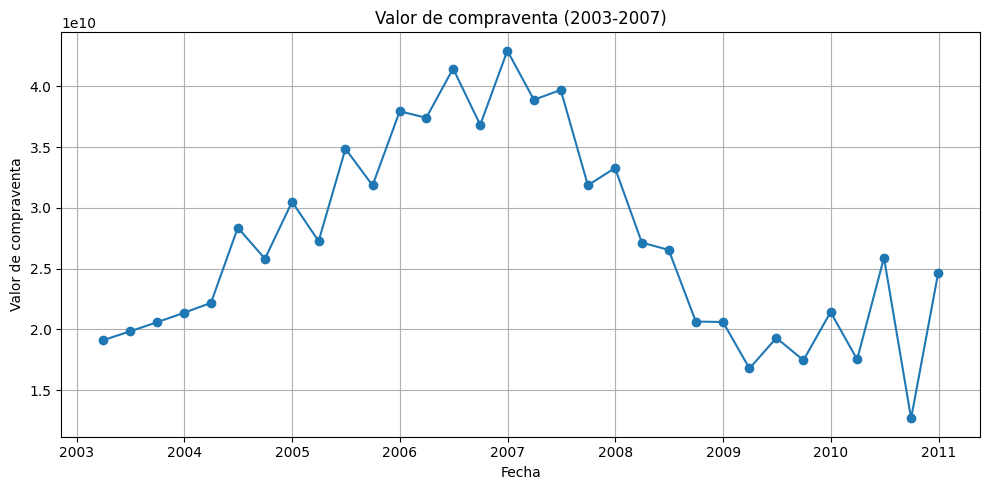

In [123]:
import matplotlib.pyplot as plt

# Filtrar los datos entre 2003 y 2007
mask = (df_clean['Fecha'] >= '2003-01-01') & (df_clean['Fecha'] <= '2010-12-31')
df_plot = df_clean.loc[mask]

plt.figure(figsize=(10,5))
plt.plot(df_plot['Fecha'], df_plot['Valor_compraventa'], marker='o', linestyle='-')
plt.title('Valor de compraventa (2003-2007)')
plt.xlabel('Fecha')
plt.ylabel('Valor de compraventa')
plt.grid(True)
plt.tight_layout()
plt.show()

### 2. Duración Media Hipoteca

En este caso, tenemos variables trimestrales desde 2009, y anuales de 2003 a 2009. Esta variable posee valores muy similares a lo largo del año, por lo que podemos sustituir estos valores anuales en los trimestres restantes de cada año sin introducir sesgos significativos.

Al tratarse de una métrica estructural como la duración media de una hipoteca, que tiende a cambiar de forma lenta y progresiva, no tiene sentido aplicar interpolación entre trimestres cuando sólo disponemos de un dato por año. Además, así evitamos fluctuaciones no reales

In [124]:
df_clean['Duracion_media_hipoteca'] = df_clean.apply(
    lambda row: df_clean[
        (df_clean['Fecha'].dt.year == row['Fecha'].year) &
        (df_clean['Fecha'].dt.quarter == 1)
    ]['Duracion_media_hipoteca'].values[0]
    if row['Fecha'].year < 2009 and pd.isna(row['Duracion_media_hipoteca']) else row['Duracion_media_hipoteca'],
    axis=1
)
df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,...,TI_Credito,Renta disponible bruta,IPC % Variación Anual,Interes_Fijo_Hipotecas,Interes_Variable_Hipotecas,Confianza_consumidor,Afiliaciones_SS,Duracion_media_hipoteca,Numero_compraventas,Valor_compraventa
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836.0,2362027.0,...,3.9805,120199,3.800000,5.15,4.29,NaN,49006568.0,23.0,183908.527902,1.910958e+10
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,NaN,NaN,...,3.707333,139387,2.900000,5.15,4.29,NaN,50002323.0,23.0,185520.576206,1.983594e+10
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231.0,2647431.0,...,3.363667,125491,3.000000,5.15,4.29,NaN,50159070.0,23.0,187146.754903,2.058991e+10
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,NaN,NaN,...,3.327,138587,2.766667,5.15,4.29,NaN,50194767.0,23.0,188787.187852,2.137254e+10
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454.0,2900788.0,...,3.303333,127391,2.233333,4.29,3.59,NaN,50448144.0,24.0,190442.000000,2.218492e+10


Este código recorre cada fila y si el año es anterior a 2009 y tiene un NaN, busca el valor del primer trimestre de ese año y lo reemplaza

### 3. Población y Cantidad de extranjeros

Las variables Población y Cantidad de Extranjeros presentan datos semestrales desde 2003 hasta 2021, mientras que el resto del dataset está en formato trimestral. Dada su evolución progresiva, se ha aplicado una interpolación lineal temporal para estimar los valores trimestrales de forma realista y coherente.

In [125]:
df_clean['Poblacion'] = df_clean.set_index('Fecha')['Poblacion'].interpolate(method='time').round().astype(int).values
df_clean['Cantidad de extranjeros'] = df_clean.set_index('Fecha')['Cantidad de extranjeros'].interpolate(method='time').round().astype(int).values
df_clean.head()

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,...,TI_Credito,Renta disponible bruta,IPC % Variación Anual,Interes_Fijo_Hipotecas,Interes_Variable_Hipotecas,Confianza_consumidor,Afiliaciones_SS,Duracion_media_hipoteca,Numero_compraventas,Valor_compraventa
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836,2362027,...,3.9805,120199,3.800000,5.15,4.29,NaN,49006568.0,23.0,183908.527902,1.910958e+10
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,42011027,2503949,...,3.707333,139387,2.900000,5.15,4.29,NaN,50002323.0,23.0,185520.576206,1.983594e+10
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231,2647431,...,3.363667,125491,3.000000,5.15,4.29,NaN,50159070.0,23.0,187146.754903,2.058991e+10
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,42372802,2774802,...,3.327,138587,2.766667,5.15,4.29,NaN,50194767.0,23.0,188787.187852,2.137254e+10
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454,2900788,...,3.303333,127391,2.233333,4.29,3.59,NaN,50448144.0,24.0,190442.000000,2.218492e+10


### 4. Confianza del consumidor

Vamos a rellenar los NaN de la variable Confianza_consumidor calculando las tasas de crecimiento trimestrales desde 2004 (año en el que empieza a haber datos) hasta 2007 (anterior a la crisis). Escogemos este período para que las tasas de crecimiento no se desvirtúen por el período posterior a la crisis, siguiendo la misma metodología aplicada para compraventas.

In [126]:
# con este codigo se me quedaban colgando los dos primeros trimestres de 2004, por lo que he tenido que hacer un codigo manual

df_24 = df_24.sort_values("Fecha").set_index("Fecha").asfreq("QE")

# Calculamos la tasa de crecimiento trimestral (pct_change)
df_24_crecimiento = df_24["Confianza_consumidor"].pct_change()

# Calculamos el crecimiento medio solo entre 2004 y 2007
crecimiento_medio = df_24_crecimiento["2004":"2007"].mean()

primer_valor_2004 = df_24["Confianza_consumidor"]["2004-09-30"]

# Calculamos valores 2003 aplicando crecimiento medio hacia atrás
valores_2003 = [primer_valor_2004 / ((1 + crecimiento_medio) ** i) for i in range(1, 5)]
fechas_2003 = pd.date_range(end="2003-12-31", periods=4, freq="QE")

df_2003 = pd.DataFrame({
    "Confianza_consumidor": valores_2003[::-1]
}, index=fechas_2003)

df_24 = pd.concat([df_2003, df_24]).sort_index().reset_index().rename(columns={"index": "Fecha"})


In [127]:
df_24 = df_24.sort_values("Fecha").set_index("Fecha").asfreq("QE")

df_24_crecimiento = df_24["Confianza_consumidor"].pct_change()

crecimiento_medio = df_24_crecimiento["2004":"2007"].mean()

primeros_2004 = df_24["Confianza_consumidor"]["2004":].dropna()
primer_valor_2004 = primeros_2004.iloc[0]
fecha_valor_2004 = primeros_2004.index[0]

num_trimestres = ((fecha_valor_2004.year - 2003) * 4 + (fecha_valor_2004.quarter - 1))

valores = [primer_valor_2004 / ((1 + crecimiento_medio) ** i) for i in range(num_trimestres, 0, -1)]
fechas = pd.date_range(start="2003-03-31", periods=num_trimestres, freq="QE")

df_fill = pd.DataFrame({
    "Confianza_consumidor": valores
}, index=fechas)

df_24 = df_24[~df_24.index.isin(fechas)]

df_24 = pd.concat([df_fill, df_24]).sort_index().reset_index().rename(columns={"index": "Fecha"})

/var/folders/cs/glwg8b695ggbr9k_ywkn40h40000gq/T/ipykernel_7142/2415504471.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_24_crecimiento = df_24["Confianza_consumidor"].pct_change()


In [128]:
df_clean = df_clean.merge(df_24, on="Fecha", how="outer")
df_clean.head(5)

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,...,Renta disponible bruta,IPC % Variación Anual,Interes_Fijo_Hipotecas,Interes_Variable_Hipotecas,Confianza_consumidor_x,Afiliaciones_SS,Duracion_media_hipoteca,Numero_compraventas,Valor_compraventa,Confianza_consumidor_y
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836,2362027,...,120199,3.800000,5.15,4.29,NaN,49006568.0,23.0,183908.527902,1.910958e+10,106.382464
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,42011027,2503949,...,139387,2.900000,5.15,4.29,NaN,50002323.0,23.0,185520.576206,1.983594e+10,104.702077
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231,2647431,...,125491,3.000000,5.15,4.29,NaN,50159070.0,23.0,187146.754903,2.058991e+10,103.048233
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,42372802,2774802,...,138587,2.766667,5.15,4.29,NaN,50194767.0,23.0,188787.187852,2.137254e+10,101.420513
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454,2900788,...,127391,2.233333,4.29,3.59,NaN,50448144.0,24.0,190442.000000,2.218492e+10,99.818504


In [129]:
df_clean = df_clean.drop(columns=["Confianza_consumidor_x"])
df_clean = df_clean.rename(columns={"Confianza_consumidor_y": "Confianza del consumidor"})
df_clean.head(5)

,Fecha,Numero Hipotecas,Importe Hipotecas,valor_medio_hipotecas,Tipo interes Medio,Tasa Paro (%),Contratos indefinidos,Contratos temporales,Poblacion,Cantidad de extranjeros,...,TI_Credito,Renta disponible bruta,IPC % Variación Anual,Interes_Fijo_Hipotecas,Interes_Variable_Hipotecas,Afiliaciones_SS,Duracion_media_hipoteca,Numero_compraventas,Valor_compraventa,Confianza del consumidor
0,2003-03-31,263600,2.417559e+10,91713.17,4.693333,11.99,9568.0,4370.2,41827836,2362027,...,3.9805,120199,3.800000,5.15,4.29,49006568.0,23.0,183908.527902,1.910958e+10,106.382464
1,2003-06-30,247071,2.340044e+10,94711.40,4.453333,11.28,9701.0,4550.9,42011027,2503949,...,3.707333,139387,2.900000,5.15,4.29,50002323.0,23.0,185520.576206,1.983594e+10,104.702077
2,2003-09-30,236977,2.397833e+10,101184.20,4.213333,11.30,9816.4,4652.2,42196231,2647431,...,3.363667,125491,3.000000,5.15,4.29,50159070.0,23.0,187146.754903,2.058991e+10,103.048233
3,2003-12-31,241791,2.462120e+10,101828.44,3.883333,11.37,9858.9,4687.5,42372802,2774802,...,3.327,138587,2.766667,5.15,4.29,50194767.0,23.0,188787.187852,2.137254e+10,101.420513
4,2004-03-31,283170,3.002192e+10,106020.83,3.760000,11.50,9914.9,4620.7,42547454,2900788,...,3.303333,127391,2.233333,4.29,3.59,50448144.0,24.0,190442.000000,2.218492e+10,99.818504


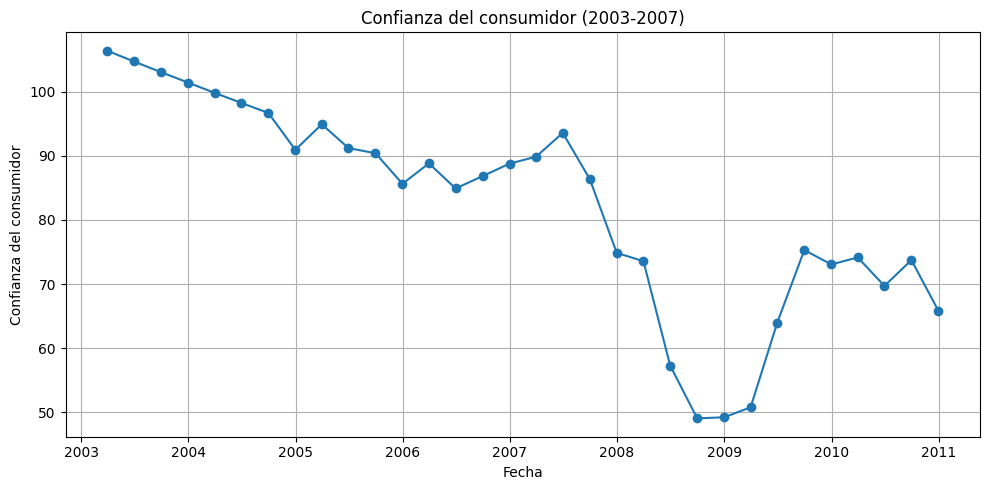

In [130]:
import matplotlib.pyplot as plt

# Filtrar los datos entre 2003 y 2007
mask = (df_clean['Fecha'] >= '2003-01-01') & (df_clean['Fecha'] <= '2010-12-31')
df_plot = df_clean.loc[mask]

plt.figure(figsize=(10,5))
plt.plot(df_plot['Fecha'], df_plot['Confianza del consumidor'], marker='o', linestyle='-')
plt.title('Confianza del consumidor (2003-2007)')
plt.xlabel('Fecha')
plt.ylabel('Confianza del consumidor')
plt.grid(True)
plt.tight_layout()
plt.show()

# Descarga del Excel con todas las variables

In [131]:
from openpyxl import load_workbook
from openpyxl.utils import get_column_letter
from openpyxl.styles import numbers
from openpyxl.styles import PatternFill

# Guardar el DataFrame en Excel sin índice
nombre_archivo = "variables_limpias.xlsx"
df_clean.to_excel(nombre_archivo, sheet_name="variables", index=False)

# Ajustar el ancho de las columnas con openpyxl
# Cargar el archivo
wb = load_workbook(nombre_archivo)
ws = wb["variables"]

# Ajustar el ancho de cada columna según el contenido más largo
for col_idx, column_cells in enumerate(ws.iter_cols(min_row=1, max_row=1), 1):
    max_length = 0
    for cell in column_cells:
        try:
            max_length = max(max_length, len(str(cell.value)))
        except:
            pass
    adjusted_width = max_length + 2  # Un poco de margen
    ws.column_dimensions[get_column_letter(col_idx)].width = adjusted_width

# Ajustar el ancho de la columna Fecha, al ser la primera es la "A"
ws.column_dimensions["A"].width = 20

# Aplicar formato de fecha corta a la columna A, si no, por defecto, Excel nos pone la fecha larga incluyendo la hora
for cell in ws["A"][1:]:  # Saltamos la cabecera
    cell.number_format = 'dd/mm/yyyy'  # Este formato Excel lo traduce como "Fecha corta"

# Definir los colores 
fill_header = PatternFill(start_color="A9D0F5", end_color="A9D0F5", fill_type="solid")  # Azul claro para encabezado
fill_gray = PatternFill(start_color="D9D9D9", end_color="D9D9D9", fill_type="solid")    # Gris claro
fill_white = PatternFill(start_color="FFFFFF", end_color="FFFFFF", fill_type="solid")

# Aplicar color al encabezado (primera fila)
for cell in ws[1]:
    cell.fill = fill_header

# Aplicar color por bloques de 4 filas
for i, row in enumerate(ws.iter_rows(min_row=2), start=0):  # min_row=2 para saltar encabezado
    fill = fill_gray if (i // 4) % 2 == 0 else fill_white
    for cell in row:
        cell.fill = fill

# Guardar el archivo actualizado
wb.save(nombre_archivo)
print("Archivo variables_limpias.xlsx guardado y formateado correctamente")

Archivo variables_limpias.xlsx guardado y formateado correctamente
